In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

pd.set_option('display.max_columns', None)
path = ''

seed=123
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Define 18 unique audio attributes
audio_cols = ['acousticness','beat_strength','bounciness','danceability','dyn_range_mean','energy','flatness','instrumentalness','key','liveness','loudness','mechanism','mode','organism','speechiness','tempo','time_signature','valence']

In [3]:
# Load raw data prepared from data_prep.ipynb
raw_data = pd.read_csv(path + 'raw_data.csv')
raw_data['mode'] = np.where(raw_data['mode'] == 'major', 1, 0)
raw_data.shape

(2990609, 50)

In [4]:
# Scale audio attributes
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(raw_data[audio_cols])
data = pd.DataFrame(data, columns=audio_cols)
data = pd.concat([raw_data.drop(audio_cols, axis=1), data], axis=1)
data

session_id  session_position  \
0        0_00006f66-33e5-4de7-a324-2d18e439fc1e                 1   
1        0_00006f66-33e5-4de7-a324-2d18e439fc1e                 2   
2        0_00006f66-33e5-4de7-a324-2d18e439fc1e                 3   
3        0_00006f66-33e5-4de7-a324-2d18e439fc1e                 4   
4        0_00006f66-33e5-4de7-a324-2d18e439fc1e                 5   
...                                         ...               ...   
2990604  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                16   
2990605  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                17   
2990606  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                18   
2990607  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                19   
2990608  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                20   

         session_length                                track_id  skip_1  \
0                    20  t_0479f24c-27d2-46d6-a00c-7ec928f2b539   False   
1                    20  t_9099cd7b-c238-47b7-9381-f23f2c1d1043   False   
2                    20  t_fc5df5ba-5396-49a7-8b29-35d0d28249e0   False   
3                    20  t_23cff8d6-d874-4b20-83dc-94e450e8aa20   False   
4                    20  t_64f3743c-f624-46bb-a579-0f3f9a07a123   False   
...                 ...                                     ...     ...   
2990604              20  t_7cfd4fc9-6811-41a2-8bea-daed723afc69    True   
2990605              20  t_5c99f04b-47c6-4307-bb21-75b068b5d078    True   
2990606              20  t_7cfd4fc9-6811-41a2-8bea-daed723afc69    True   
2990607              20  t_5c99f04b-47c6-4307-bb21-75b068b5d078   False   
2990608              20  t_7cfd4fc9-6811-41a2-8bea-daed723afc69    True   

         skip_2  skip_3  not_skipped  context_switch  no_pause_before_play  \
0         False   False         True           False                 False   
1         False   False         True           False                  True   
2         False   False         True           False                  True   
3         False   False         True           False                  True   
4         False   False         True           False                  True   
...         ...     ...          ...             ...                   ...   
2990604    True    True        False           False                  True   
2990605    True    True        False           False                  True   
2990606    True    True        False           False                  True   
2990607   False    True        False           False                  True   
2990608    True    True        False           False                  True   

         short_pause_before_play  long_pause_before_play  \
0                          False                   False   
1                          False                   False   
2                          False                   False   
3                          False                   False   
4                          False                   False   
...                          ...                     ...   
2990604                    False                   False   
2990605                    False                   False   
2990606                    False                   False   
2990607                    False                   False   
2990608                    False                   False   

         hist_user_behavior_n_seekfwd  hist_user_behavior_n_seekback  \
0                                   0                              0   
1                                   0                              0   
2                                   0                              0   
3                                   0                              0   
4                                   0                              0   
...                               ...                            ...   
2990604                             0                              0   
2990605                             0                              0   
2

In [5]:
# Calculate average standard deviation across sessions for each feature to be used in the prior
avg_stds = data[['session_id'] + audio_cols].groupby('session_id').std().mean()
avg_stds

acousticness        0.197610
beat_strength       0.117480
bounciness          0.127420
danceability        0.120791
dyn_range_mean      0.047141
energy              0.145998
flatness            0.024551
instrumentalness    0.050162
key                 0.326285
liveness            0.127903
loudness            0.035528
mechanism           0.171552
mode                0.457627
organism            0.156613
speechiness         0.100381
tempo               0.115229
time_signature      0.037554
valence             0.191716
dtype: float64

## Changepoint Detection using Hidden Markov Models

In [6]:
NUM_STATES = 10
NUM_EXAMPLES = 10000 # Note: A total of 50,000 sesssions were analysed in original paper
MAX_SESSION_LENGTH = 20

# Uniform initial distribution
initial_state_logits = np.zeros([NUM_STATES])

# Define equal transition probabilities across each of the states
daily_change_prob = 1 - 1/NUM_STATES
transition_probs = daily_change_prob / (NUM_STATES-1) * np.ones([NUM_STATES, NUM_STATES])
np.fill_diagonal(transition_probs, 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Transition matrix:
[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]


In [7]:
# Take a sampled subset of sessions
sess_ids = pd.Series(data['session_id'].unique()).sample(NUM_EXAMPLES, random_state=seed).sort_values()
sess_ids 

21        0_00074d75-33c6-40b3-99e1-a88e9d015e42
35        0_000bd318-caf2-4366-ba56-26db623b083d
67        0_00130aaf-66be-4824-be3a-d41f8b8caafb
68        0_00137cc4-c737-4b01-9e72-1161f3723b72
83        0_00186766-ee41-49da-8e39-328bbef70f23
                           ...                  
178259    0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa
178270    0_ffe119a4-9b10-4ede-9119-99046d498767
178291    0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58
178311    0_fff3f41f-183a-4664-a623-6db01ab871bc
178339    0_ffff16ed-55b2-455d-ab42-f716d50ffbaf
Length: 10000, dtype: object

In [8]:
# Prepare tensor of audio attributes X no. of sessions X session length
# Pad sessions which are shorter than 20 with zeros
# Also, calculate mean & std for each session

sampled_data = data[data['session_id'].isin(sess_ids)].reset_index(drop=True)

observed_values = [sampled_data[['session_id', col]].groupby('session_id') for col in audio_cols]
observed_values = observed_means_stds = [[feat.get_group(x).iloc[:,1].values for x in feat.groups] for feat in observed_values]

observed_values = np.array([np.stack([np.pad(sess, (0,MAX_SESSION_LENGTH-len(sess)), 'edge') for sess in feat]) for feat in observed_values])
observed_means_stds = np.array([np.stack([[np.mean(sess), np.std(sess)] for sess in feat]) for feat in observed_means_stds])
    
observed_values = np.array(observed_values).astype('float32')
observed_means_stds = np.array(observed_means_stds).astype('float32')

observed_values.shape, observed_means_stds.shape

((18, 10000, 20), (18, 10000, 2))

In [9]:
observed_values = observed_values.reshape(len(audio_cols) * NUM_EXAMPLES,MAX_SESSION_LENGTH)
observed_means_stds = observed_means_stds.reshape(len(audio_cols) * NUM_EXAMPLES,2)

trainable_means = tf.Variable(
    (observed_means_stds[:,0].reshape(-1,1) * np.ones(NUM_STATES) + tf.random.normal([1, NUM_STATES], seed=seed)),
    name='means')

print(observed_values.shape, observed_means_stds.shape, trainable_means.shape)

(180000, 20) (180000, 2) (180000, 10)


In [10]:
# Define std for each feature in each session to be the avg std of that feature across all sessions
stds = []
for i, col in enumerate(audio_cols):
    if stds == []:
        stds = avg_stds[col] * np.ones([NUM_EXAMPLES, NUM_STATES]).astype('float32')
    else:
        stds = np.vstack([stds, avg_stds[col] * np.ones([NUM_EXAMPLES, NUM_STATES]).astype('float32')])
stds = stds.astype('float32')
stds.shape

/Users/aaronng/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


(180000, 10)

In [11]:
# Define a HMM with a categorical distribution for initial and transition distribution,
# and normal distribution for observation distribution

hmm = tfd.HiddenMarkovModel(
      initial_distribution=tfd.Categorical(logits=initial_state_logits),
      transition_distribution=tfd.Categorical(probs=transition_probs),
      observation_distribution=tfd.Normal(trainable_means, stds),
      num_steps=MAX_SESSION_LENGTH)

In [12]:
# Apply each session's prior to all states, summing them up, before adding to log_prob of observed values

def log_prob():
  prior = tfd.Normal(observed_means_stds[:,0], stds[:,0].astype('float32'))
  return prior.log_prob(trainable_means[:,0]) \
+ prior.log_prob(trainable_means[:,1]) \
+ prior.log_prob(trainable_means[:,2]) \
+ prior.log_prob(trainable_means[:,3]) \
+ prior.log_prob(trainable_means[:,4]) \
+ prior.log_prob(trainable_means[:,5]) \
+ prior.log_prob(trainable_means[:,6]) \
+ prior.log_prob(trainable_means[:,7]) \
+ prior.log_prob(trainable_means[:,8]) \
+ prior.log_prob(trainable_means[:,9]) \
+ hmm.log_prob(observed_values)

In [13]:
# Train HMM using Adam optimizer

import time
start_time = time.time()

@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_means])[0]
  optimizer.apply_gradients([(grads, trainable_means)])
  return neg_log_prob, trainable_means

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
for step in range(201):
  loss, means = [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: loss {}".format(step, -loss))

print('Time taken: {}'.format(time.time() - start_time))

step 0: loss [-112.0585  -112.16264 -131.33319 ... -142.74126 -128.53494 -122.69444]
step 20: loss [-6.3963866  8.446798  18.88236   ... 16.02404   12.470394   7.619665 ]
step 40: loss [-3.3522015 10.171915  19.021673  ... 18.009377  14.28415    9.046806 ]
step 60: loss [-1.8721465 10.411097  19.814682  ... 18.612305  14.32453    9.260878 ]
step 80: loss [-1.5681984 10.502403  19.960691  ... 18.687534  14.400196   9.309872 ]
step 100: loss [-1.5318675 10.509748  19.97006   ... 18.70244   14.4034605  9.3153   ]
step 120: loss [-1.5240302 10.510271  19.972652  ... 18.703804  14.40465    9.316726 ]
step 140: loss [-1.5234733 10.51036   19.972767  ... 18.704018  14.404867   9.316823 ]
step 160: loss [-1.523447  10.510376  19.97279   ... 18.704037  14.404892   9.3168335]
step 180: loss [-1.5234387 10.510377  19.972797  ... 18.704042  14.404893   9.316835 ]
step 200: loss [-1.5234368 10.510378  19.972797  ... 18.704044  14.404893   9.316834 ]
Time taken: 1421.4264860153198


In [15]:
# Calculate posterior marginals and find most probable state for each timestep
posterior_probs = hmm.posterior_marginals(observed_values).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)

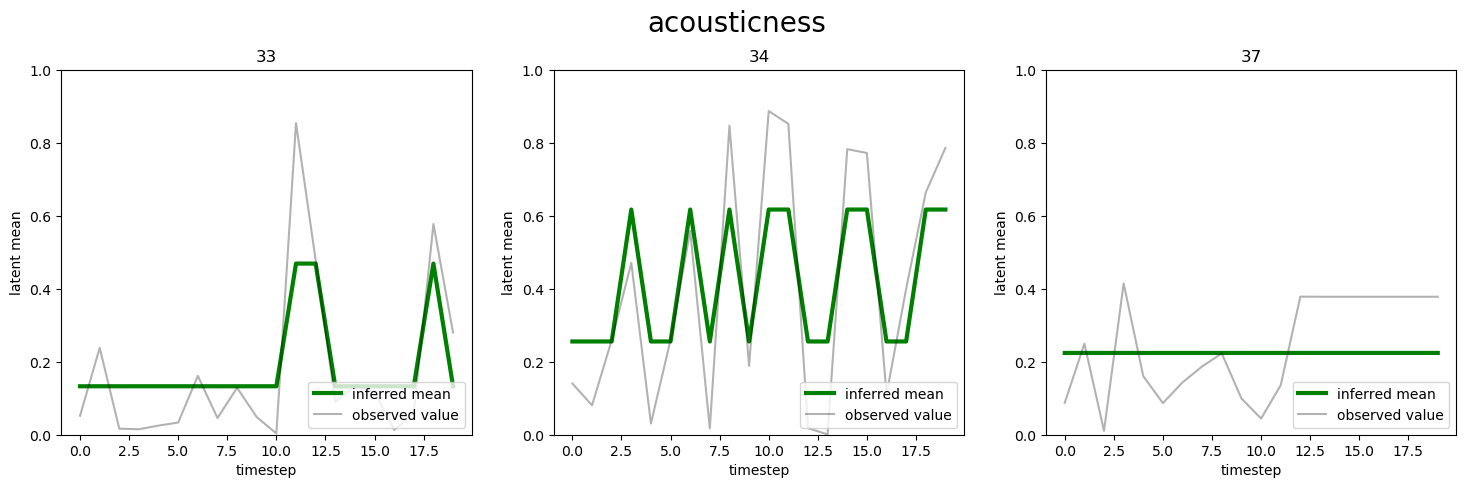

In [20]:
# Example plots of latent states and original values for acousticness in a few sessions
AUDIO_COL_IDX = 0

plt.rcParams.update(plt.rcParamsDefault)
fig = plt.figure(figsize=(18, 20))
sampled_idxs = [32,33,36]

fig.suptitle(audio_cols[AUDIO_COL_IDX], fontsize=20)
fig.subplots_adjust(top=0.95)

start_idx = AUDIO_COL_IDX * NUM_EXAMPLES
end_idx = (AUDIO_COL_IDX+1) * NUM_EXAMPLES

means_col = means[start_idx:end_idx, :]
most_probable_states_col = most_probable_states[start_idx:end_idx, :]
observed_values_col = observed_values[start_idx:end_idx, :]

for k, i in enumerate(sampled_idxs):
  ax = fig.add_subplot(4, 3, k+1)
  ax.plot(means_col[i][most_probable_states_col[i]], c='green', lw=3, label='inferred mean')
  ax.plot(observed_values_col[i], c='black', alpha=0.3, label='observed value')
  ax.set_ylabel("latent mean")
  ax.set_xlabel("timestep")
  ax.set_ylim(0,1)
  ax.set_title("{}".format(i+1))
  ax.legend(loc=4)

plt.show()

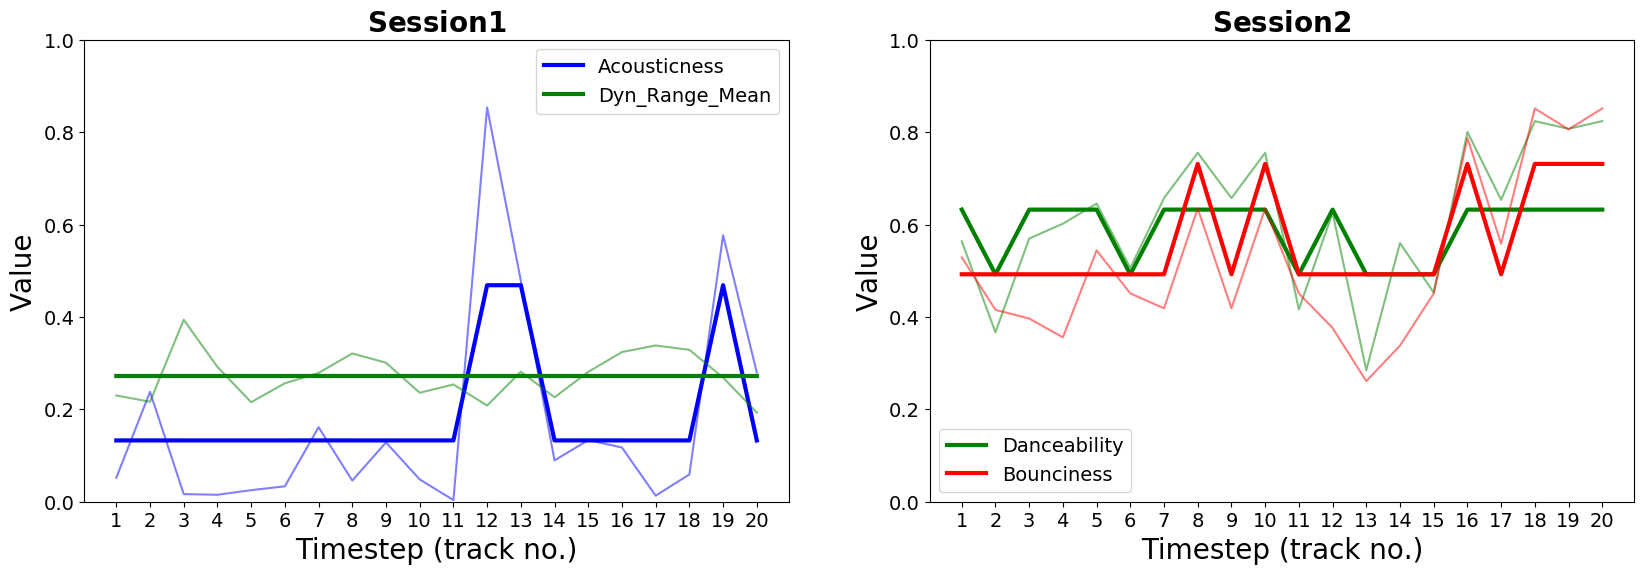

In [48]:
# Example plots of latent states and original values for 2 audio attributes across different sessions

AUDIO_COL_IDX_1 = 3 # Danceability
AUDIO_COL_IDX_2 = 0 # Acousticness

colors = 'bgrbgrbg'
fig, ax = plt.subplots(1,2,figsize=(20,6))
# plt.subplots_adjust(hspace=0.3)
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

def plot(ax, x, n, i, AUDIO_COL_IDX_1, AUDIO_COL_IDX_2, audio_col_1, audio_col_2, means, most_probable_states, observed_values):
    start_idx_1 = AUDIO_COL_IDX_1 * NUM_EXAMPLES
    end_idx_1 = (AUDIO_COL_IDX_1+1) * NUM_EXAMPLES
    start_idx_2 = AUDIO_COL_IDX_2 * NUM_EXAMPLES
    end_idx_2 = (AUDIO_COL_IDX_2+1) * NUM_EXAMPLES

    means_col_1 = means[start_idx_1:end_idx_1, :]
    most_probable_states_col_1 = most_probable_states[start_idx_1:end_idx_1, :]
    observed_values_col_1 = observed_values[start_idx_1:end_idx_1, :]
    means_col_2 = means[start_idx_2:end_idx_2, :]
    most_probable_states_col_2 = most_probable_states[start_idx_2:end_idx_2, :]
    observed_values_col_2 = observed_values[start_idx_2:end_idx_2, :]

    color1 = colors[n-1]
    color2 = colors[n-1+4]
    ax[x].plot(means_col_1[i][most_probable_states_col_1[i]], c=color1, lw=3, label=audio_col_1)
    ax[x].plot(observed_values_col_1[i], c=color1, alpha=0.5)
    ax[x].plot(means_col_2[i][most_probable_states_col_2[i]], c=color2, lw=3, label=audio_col_2)
    ax[x].plot(observed_values_col_2[i], c=color2, alpha=0.5)
    ax[x].set_ylabel("Value")
    ax[x].set_xlabel("Timestep (track no.)")
    ax[x].set_xticks(range(0,20))
    ax[x].set_xticklabels(range(1,21))
    ax[x].set_ylim(0,1)
    ax[x].set_title(r"$\bf{Session "+str(n)+"}$")
    if x ==0:
        ax[x].legend(loc='upper right')
    else:
        ax[x].legend(loc='lower left')

# plot(ax,0,0,1,49835,0,1,'Danceability','Beat Strength',means, most_probable_states, observed_values)
plot(ax,0,1,32,0,4,'Acousticness','Dyn_Range_Mean',means, most_probable_states, observed_values)
plot(ax,1,2,555,3,2,'Danceability','Bounciness',means, most_probable_states, observed_values)
# plot(ax,1,0,3,77,4,2,'Dyn_Range_Mean','Bounciness',means, most_probable_states, observed_values)
# plot(ax,1,0,3,14232,10,11,'Loudness','Mechanism',means, most_probable_states, observed_values)
# plot(ax,1,1,4,22,4,2,'Dyn_Range_Mean','Bounciness',means, most_probable_states, observed_values)
# plot(ax,1,1,4,22,6,17,'Flatness','Valence',means, most_probable_states, observed_values)
# plot(ax,1,1,4,49815,6,5,'Flatness','Valence',means, most_probable_states, observed_values)

plt.show()

# plt.savefig('two_states_example.png', dpi=300)

In [54]:
# No. of states per audio attribute before merging similar states
num_states_features = pd.DataFrame(pd.Series(np.arange(1,11), name='index'))

for i, col in enumerate(audio_cols):
    num_states = pd.DataFrame(most_probable_states[i * NUM_EXAMPLES:(i+1)* NUM_EXAMPLES]) \
                .nunique(axis=1).value_counts().sort_index().reset_index().rename(columns={0:col})
    num_states_features = num_states_features.merge(num_states, on='index', how='left')

num_states_features = num_states_features.rename(columns={'index':'num_states'})
num_states_features = num_states_features.set_index('num_states')
num_states_features

acousticness  beat_strength  bounciness  danceability  \
num_states                                                          
1                    8.0            1.0         1.0           1.0   
2                 5345.0         6677.0      6353.0        6578.0   
3                 3468.0         2485.0      2661.0        2616.0   
4                 1048.0          739.0       873.0         708.0   
5                  123.0           84.0        98.0          87.0   
6                    8.0           12.0        10.0           9.0   
7                    NaN            2.0         4.0           1.0   
8                    NaN            NaN         NaN           NaN   
9                    NaN            NaN         NaN           NaN   
10                   NaN            NaN         NaN           NaN   

            dyn_range_mean  energy  flatness  instrumentalness     key  \
num_states                                                               
1                      1.0     1.0       1.0            1492.0     6.0   
2                   6352.0  6602.0    7087.0            4807.0  8557.0   
3                   2775.0  2517.0    2172.0            2970.0  1317.0   
4                    748.0   791.0     594.0             609.0   113.0   
5                    113.0    76.0     121.0             113.0     7.0   
6                     10.0    13.0      23.0               9.0     NaN   
7                      1.0     NaN       1.0               NaN     NaN   
8                      NaN     NaN       1.0               NaN     NaN   
9                      NaN     NaN       NaN               NaN     NaN   
10                     NaN     NaN       NaN               NaN     NaN   

            liveness  loudness  mechanism    mode  organism  speechiness  \
num_states                                                                 
1                2.0       1.0        1.0   262.0       1.0          1.0   
2             5702.0    6441.0     6534.0  9214.0    6502.0       5026.0   
3             3595.0    2780.0     2501.0   522.0    2658.0       3735.0   
4              635.0     661.0      892.0     2.0     789.0       1089.0   
5               58.0     105.0       65.0     NaN      46.0        140.0   
6                7.0      12.0        6.0     NaN       4.0          7.0   
7                1.0       NaN        1.0     NaN       NaN          2.0   
8                NaN       NaN        NaN     NaN       NaN          NaN   
9                NaN       NaN        NaN     NaN       NaN          NaN   
10               NaN       NaN        NaN     NaN       NaN          NaN   

             tempo  time_signature  valence  
num_states                                   
1              3.0          5324.0      2.0  
2           7548.0          3634.0   7291.0  
3           1932.0           957.0   2032.0  
4            472.0            83.0    624.0  
5             45.0             2.0     48.0  
6              NaN             NaN      3.0  
7              NaN             NaN      NaN  
8              NaN             NaN      NaN  
9              NaN             NaN      NaN  
10             NaN             NaN      NaN

In [55]:
truncate = np.vectorize(lambda n: int(n * 100) / 100)

def merge_states(states, means):
    means = truncate(means) # Round down to nearest 0.01
    grouped_states = [np.where(means == i)[0].tolist() for i in np.unique(means)]
    
    # Map each state to first state in group
    map_states = {}
    for group in grouped_states:
        for i in group:
            map_states[i] = group[0]

    fn = np.vectorize(lambda x: map_states[x])
    return fn(states)

In [56]:
# Merge similar states
most_probable_states_merged = [merge_states(s,m) for s,m in zip(most_probable_states,means)]

In [57]:
# No. of states per audio attribute after merging similar states
num_states_features = pd.DataFrame(pd.Series(np.arange(1,11), name='index'))

for i, col in enumerate(audio_cols):
    num_states = pd.DataFrame(most_probable_states_merged[i * NUM_EXAMPLES:(i+1)* NUM_EXAMPLES]) \
                .nunique(axis=1).value_counts().sort_index().reset_index().rename(columns={0:col})
    num_states_features = num_states_features.merge(num_states, on='index', how='left')

num_states_features = num_states_features.rename(columns={'index':'num_states'})
num_states_features = num_states_features.set_index('num_states')
num_states_features

acousticness  beat_strength  bounciness  danceability  \
num_states                                                          
1                 6562.0         8147.0      7828.0        8037.0   
2                 3370.0         1664.0      1940.0        1750.0   
3                   58.0          157.0       193.0         168.0   
4                   10.0           20.0        27.0          34.0   
5                    NaN            8.0        11.0          10.0   
6                    NaN            4.0         1.0           1.0   
7                    NaN            NaN         NaN           NaN   
8                    NaN            NaN         NaN           NaN   
9                    NaN            NaN         NaN           NaN   
10                   NaN            NaN         NaN           NaN   

            dyn_range_mean  energy  flatness  instrumentalness     key  \
num_states                                                               
1                   7420.0  8020.0    7984.0            7678.0  9169.0   
2                   2350.0  1771.0    1730.0            1788.0   816.0   
3                    191.0   167.0     258.0             399.0    14.0   
4                     35.0    37.0      23.0             125.0     1.0   
5                      4.0     3.0       4.0              10.0     NaN   
6                      NaN     2.0       1.0               NaN     NaN   
7                      NaN     NaN       NaN               NaN     NaN   
8                      NaN     NaN       NaN               NaN     NaN   
9                      NaN     NaN       NaN               NaN     NaN   
10                     NaN     NaN       NaN               NaN     NaN   

            liveness  loudness  mechanism    mode  organism  speechiness  \
num_states                                                                 
1             6962.0    7660.0     7787.0  4572.0    7910.0       6494.0   
2             2964.0    2068.0     2057.0  5428.0    1946.0       3221.0   
3               68.0     237.0      135.0     NaN     114.0        255.0   
4                5.0      34.0       17.0     NaN      30.0         20.0   
5                1.0       1.0        4.0     NaN       NaN          9.0   
6                NaN       NaN        NaN     NaN       NaN          1.0   
7                NaN       NaN        NaN     NaN       NaN          NaN   
8                NaN       NaN        NaN     NaN       NaN          NaN   
9                NaN       NaN        NaN     NaN       NaN          NaN   
10               NaN       NaN        NaN     NaN       NaN          NaN   

             tempo  time_signature  valence  
num_states                                   
1           8625.0          5324.0   8606.0  
2           1276.0          3707.0   1261.0  
3             91.0           904.0    122.0  
4              8.0            65.0     11.0  
5              NaN             NaN      NaN  
6              NaN             NaN      NaN  
7              NaN             NaN      NaN  
8              NaN             NaN      NaN  
9              NaN             NaN      NaN  
10             NaN             NaN      NaN

## Analysis on states

In [58]:
observed_skips = sampled_data[['session_id', 'skip_2']].groupby('session_id')
observed_skips = [observed_skips.get_group(x).iloc[:,1].values for x in observed_skips.groups]
observed_skips = np.stack([np.pad(sess, (0,MAX_SESSION_LENGTH-len(sess)), 'edge') for sess in observed_skips])
observed_skips = observed_skips.astype(int)
observed_skips.shape

(10000, 20)

In [59]:
session_lengths = sampled_data[['session_id','session_length']].groupby('session_id').mean()['session_length'].values
session_lengths.shape

(10000,)

In [ ]:
# Calculate num of skips for each state in each audio attribute across all sessions
all_skips_per_state = []

for i, (sess_states,sess_means_all) in enumerate(zip(most_probable_states_merged,means)):
    idx = i % NUM_EXAMPLES
    
    sess_means_all = truncate(sess_means_all)
    sess_states = sess_states[:session_lengths[idx]]
    sess_means = [sess_means_all[s] for s in sess_states]

    session = pd.DataFrame(sess_means, columns=['means'])
    session['skip_2'] = observed_skips[idx][:session_lengths[idx]]
    
    session = session.sort_values(['means','skip_2'])
    sess_state_skips = session.groupby('means').agg(lambda x: [list(x).count(0), list(x).count(1)]).reset_index()
    
    all_skips_per_state.append(sess_state_skips)
    
    if i%1000 == 0:
        print('Processed {} sessions'.format(i))

In [61]:
# [No. of non-skips, no. of skips] for each state in each feature across all sessions
tmp = [x['skip_2'].values for x in all_skips_per_state]

states_skips_all = pd.DataFrame(
    np.array(tmp).reshape(len(audio_cols), NUM_EXAMPLES).transpose(), 
    columns=audio_cols, 
    index=sampled_data['session_id'].unique()
)
states_skips_all

acousticness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42  [[5, 9], [1, 0]]   
0_000bd318-caf2-4366-ba56-26db623b083d  [[3, 8], [1, 2]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb         [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72         [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23          [[8, 3]]   
...                                                  ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa         [[2, 18]]   
0_ffe119a4-9b10-4ede-9119-99046d498767         [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58  [[0, 5], [4, 1]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc         [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf  [[9, 1], [7, 1]]   

                                                    beat_strength  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                   [[6, 9]]   
0_000bd318-caf2-4366-ba56-26db623b083d                  [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                  [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72                  [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23                   [[8, 3]]   
...                                                           ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [[1, 4], [0, 1], [1, 13]]   
0_ffe119a4-9b10-4ede-9119-99046d498767                  [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                   [[4, 6]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc                  [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                  [[16, 2]]   

                                                       bounciness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           [[3, 7], [3, 2]]   
0_000bd318-caf2-4366-ba56-26db623b083d                  [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                  [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72                  [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23                   [[8, 3]]   
...                                                           ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [[1, 4], [0, 4], [1, 10]]   
0_ffe119a4-9b10-4ede-9119-99046d498767                  [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                   [[4, 6]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc                  [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                  [[16, 2]]   

                                             danceability     dyn_range_mean  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           [[6, 9]]   [[4, 8], [2, 1]]   
0_000bd318-caf2-4366-ba56-26db623b083d          [[4, 10]]          [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb          [[5, 15]]          [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72          [[7, 13]]          [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23           [[8, 3]]   [[4, 1], [4, 2]]   
...                                                   ...                ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [[1, 4], [1, 14]]  [[1, 6], [1, 12]]   
0_ffe119a4-9b10-4ede-9119-99046d498767          [[8, 12]]          [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58           [[4, 6]]           [[4, 6]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc          [[15, 3]]          [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf   [[9, 2], [7, 0]]          [[16, 2]]   

                                                                  energy  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                          [[6, 9]]   
0_000bd318-caf2-4366-ba56-26db623b083d                         [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                         [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72                         [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23                          [[8, 3]]   
...                                                                  ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa                         [[2, 18]]   
0_ffe119a4-9b10-4ede-9119-99046d498767                         [[8, 12]]   
0_ffeb9687-caff-4b4a

In [62]:
session_data = sampled_data[['session_id', 'session_length', 'skip_2']]
session_data = session_data.groupby(['session_id']).mean()
session_data = session_data.reset_index()
session_data

session_id  session_length    skip_2
0     0_00074d75-33c6-40b3-99e1-a88e9d015e42              15  0.600000
1     0_000bd318-caf2-4366-ba56-26db623b083d              14  0.714286
2     0_00130aaf-66be-4824-be3a-d41f8b8caafb              20  0.750000
3     0_00137cc4-c737-4b01-9e72-1161f3723b72              20  0.650000
4     0_00186766-ee41-49da-8e39-328bbef70f23              11  0.272727
...                                      ...             ...       ...
9995  0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa              20  0.900000
9996  0_ffe119a4-9b10-4ede-9119-99046d498767              20  0.600000
9997  0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58              10  0.600000
9998  0_fff3f41f-183a-4664-a623-6db01ab871bc              18  0.166667
9999  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf              18  0.111111

[10000 rows x 3 columns]

In [63]:
def avg(x):
    return x[1] / np.sum(x)
def mapTo0(x, threshold, num_tracks):
    return (avg(x) <= threshold) and (np.sum(x) >= num_tracks)
def mapTo1(x, threshold, num_tracks):
    return (avg(x) >= (1-threshold)) and (np.sum(x) >= num_tracks)

# Define matching/filtering criterias for states
def match(states, num_states=2, num_tracks=3, threshold=0.25, return_states=False, return_matched_states=True):
    # At least num_states
    if len(states) < num_states:
        return 'N/A'
    
    if threshold != None:
        # At least 1 state maps near to 0 and has at least num_tracks
        if not any([mapTo0(skip_split, threshold, num_tracks) for skip_split in states]):
            return False
        # At least 1 state maps near to 1 and has at least num_tracks
        if not any([mapTo1(skip_split, threshold, num_tracks) for skip_split in states]):
            return False

    if return_matched_states == True:
        if threshold == None:
            matched_states = [s for s in states if np.sum(s) >= num_tracks]
        else:
            matched_states = [s for s in states if (mapTo0(s, threshold, num_tracks) == True) or (mapTo1(s, threshold, num_tracks) == True)] 

        states = list(matched_states) if len(matched_states) >= num_states else 'N/A'
        
    return states if return_states else True

In [64]:
# [No. of non-skips, no. of skips] for each state in each feature across all sessions
# AFTER filtering states with 2 or fewer tracks (outlier states)
filt = lambda x: match(x, num_states=1, num_tracks=3, threshold=None, return_states=False)
states_filt_bool = states_skips_all.applymap(filt)
states_filt_ids = states_filt_bool[states_filt_bool[states_filt_bool == True].any(axis=1)].index

filt = lambda x: match(x, num_states=1, num_tracks=3, threshold=None, return_states=True, return_matched_states=True)
states_filt = states_skips_all.loc[states_filt_ids].applymap(filt)
states_filt

acousticness      beat_strength  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42          [[5, 9]]           [[6, 9]]   
0_000bd318-caf2-4366-ba56-26db623b083d  [[3, 8], [1, 2]]          [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb         [[5, 15]]          [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72         [[7, 13]]          [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23          [[8, 3]]           [[8, 3]]   
...                                                  ...                ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa         [[2, 18]]  [[1, 4], [1, 13]]   
0_ffe119a4-9b10-4ede-9119-99046d498767         [[8, 12]]          [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58  [[0, 5], [4, 1]]           [[4, 6]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc         [[15, 3]]          [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf  [[9, 1], [7, 1]]          [[16, 2]]   

                                                       bounciness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           [[3, 7], [3, 2]]   
0_000bd318-caf2-4366-ba56-26db623b083d                  [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                  [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72                  [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23                   [[8, 3]]   
...                                                           ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [[1, 4], [0, 4], [1, 10]]   
0_ffe119a4-9b10-4ede-9119-99046d498767                  [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                   [[4, 6]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc                  [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                  [[16, 2]]   

                                             danceability     dyn_range_mean  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           [[6, 9]]   [[4, 8], [2, 1]]   
0_000bd318-caf2-4366-ba56-26db623b083d          [[4, 10]]          [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb          [[5, 15]]          [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72          [[7, 13]]          [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23           [[8, 3]]   [[4, 1], [4, 2]]   
...                                                   ...                ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [[1, 4], [1, 14]]  [[1, 6], [1, 12]]   
0_ffe119a4-9b10-4ede-9119-99046d498767          [[8, 12]]          [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58           [[4, 6]]           [[4, 6]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc          [[15, 3]]          [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf   [[9, 2], [7, 0]]          [[16, 2]]   

                                                          energy  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                  [[6, 9]]   
0_000bd318-caf2-4366-ba56-26db623b083d                 [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                 [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72                 [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23                  [[8, 3]]   
...                                                          ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa                 [[2, 18]]   
0_ffe119a4-9b10-4ede-9119-99046d498767                 [[8, 12]]   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                  [[4, 6]]   
0_fff3f41f-183a-4664-a623-6db01ab871bc                 [[15, 3]]   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf  [[7, 2], [3, 0], [5, 0]]   

                                                 flatness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           [[6, 9]]   
0_000bd318-caf2-4366-ba56-26db623b083d          [[4, 10]]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb          [[5, 15]]   
0_00137cc4-c737-4b01-9e72-1161f3723b72          [[7, 13]]   
0_00186766-ee41-49da-8e39-328bbef70f23           [[8, 3]]   
...                                                   ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa          [[2, 18]]   


In [65]:
# No. of sessions with num_states across features
num_states_filt = states_filt.applymap(lambda x: len(x) if isinstance(x, list) else 1) \
                .apply(pd.Series.value_counts).fillna(0)

# Total sum per column: 
num_states_filt.loc['Total',:]= num_states_filt.sum(axis=0)

# Total sum per row: 
num_states_filt.loc[:,'Total'] = num_states_filt.sum(axis=1)

num_states_filt

acousticness  beat_strength  bounciness  danceability  dyn_range_mean  \
1            6957.0         8229.0      7943.0        8148.0          7618.0   
2            3023.0         1670.0      1927.0        1736.0          2228.0   
3              19.0          100.0       129.0         109.0           147.0   
4               1.0            0.0         1.0           7.0             7.0   
5               0.0            1.0         0.0           0.0             0.0   
Total       10000.0        10000.0     10000.0       10000.0         10000.0   

        energy  flatness  instrumentalness      key  liveness  loudness  \
1       8157.0    8212.0            9251.0   9179.0    7813.0    8087.0   
2       1733.0    1590.0             619.0    820.0    2141.0    1732.0   
3        104.0     192.0             115.0      1.0      46.0     175.0   
4          6.0       6.0              15.0      0.0       0.0       6.0   
5          0.0       0.0               0.0      0.0       0.0       0.0   
Total  10000.0   10000.0           10000.0  10000.0   10000.0   10000.0   

       mechanism     mode  organism  speechiness    tempo  time_signature  \
1         7877.0   4871.0    8037.0       6968.0   8667.0          9071.0   
2         2063.0   5129.0    1904.0       2862.0   1304.0           890.0   
3           60.0      0.0      55.0        164.0     28.0            36.0   
4            0.0      0.0       4.0          6.0      1.0             3.0   
5            0.0      0.0       0.0          0.0      0.0             0.0   
Total    10000.0  10000.0   10000.0      10000.0  10000.0         10000.0   

       valence     Total  
1       8654.0  143739.0  
2       1290.0   34661.0  
3         56.0    1536.0  
4          0.0      63.0  
5          0.0       1.0  
Total  10000.0  180000.0

In [66]:
# Percentage of sessions with num_states across selected features
cols_23 = ['acousticness','liveness','mechanism','bounciness','danceability','time_signature','key','instrumentalness']

def highlight_max(s, n=2):
    # Get 5 largest values of the column
    is_large = s.nlargest(n).values
    # Apply style is the current value is among the 5 biggest values
    return ['font-weight: bold' if v in is_large else '' for v in s]

t1 = copy.deepcopy(num_states_filt.drop('Total'))
t1[audio_cols] = t1[audio_cols] / NUM_EXAMPLES * 100
t1 = t1[cols_23]
# t = t.drop(0)
t1.index.name = 'num_states'
# t = t.style.apply(highlight_max).set_caption('% of sessions with num_states across features')
# t = t.format('{0:,.2f}')
t1

acousticness  liveness  mechanism  bounciness  danceability  \
num_states                                                                
1                  69.57     78.13      78.77       79.43         81.48   
2                  30.23     21.41      20.63       19.27         17.36   
3                   0.19      0.46       0.60        1.29          1.09   
4                   0.01      0.00       0.00        0.01          0.07   
5                   0.00      0.00       0.00        0.00          0.00   

            time_signature    key  instrumentalness  
num_states                                           
1                    90.71  91.79             92.51  
2                     8.90   8.20              6.19  
3                     0.36   0.01              1.15  
4                     0.03   0.00              0.15  
5                     0.00   0.00              0.00

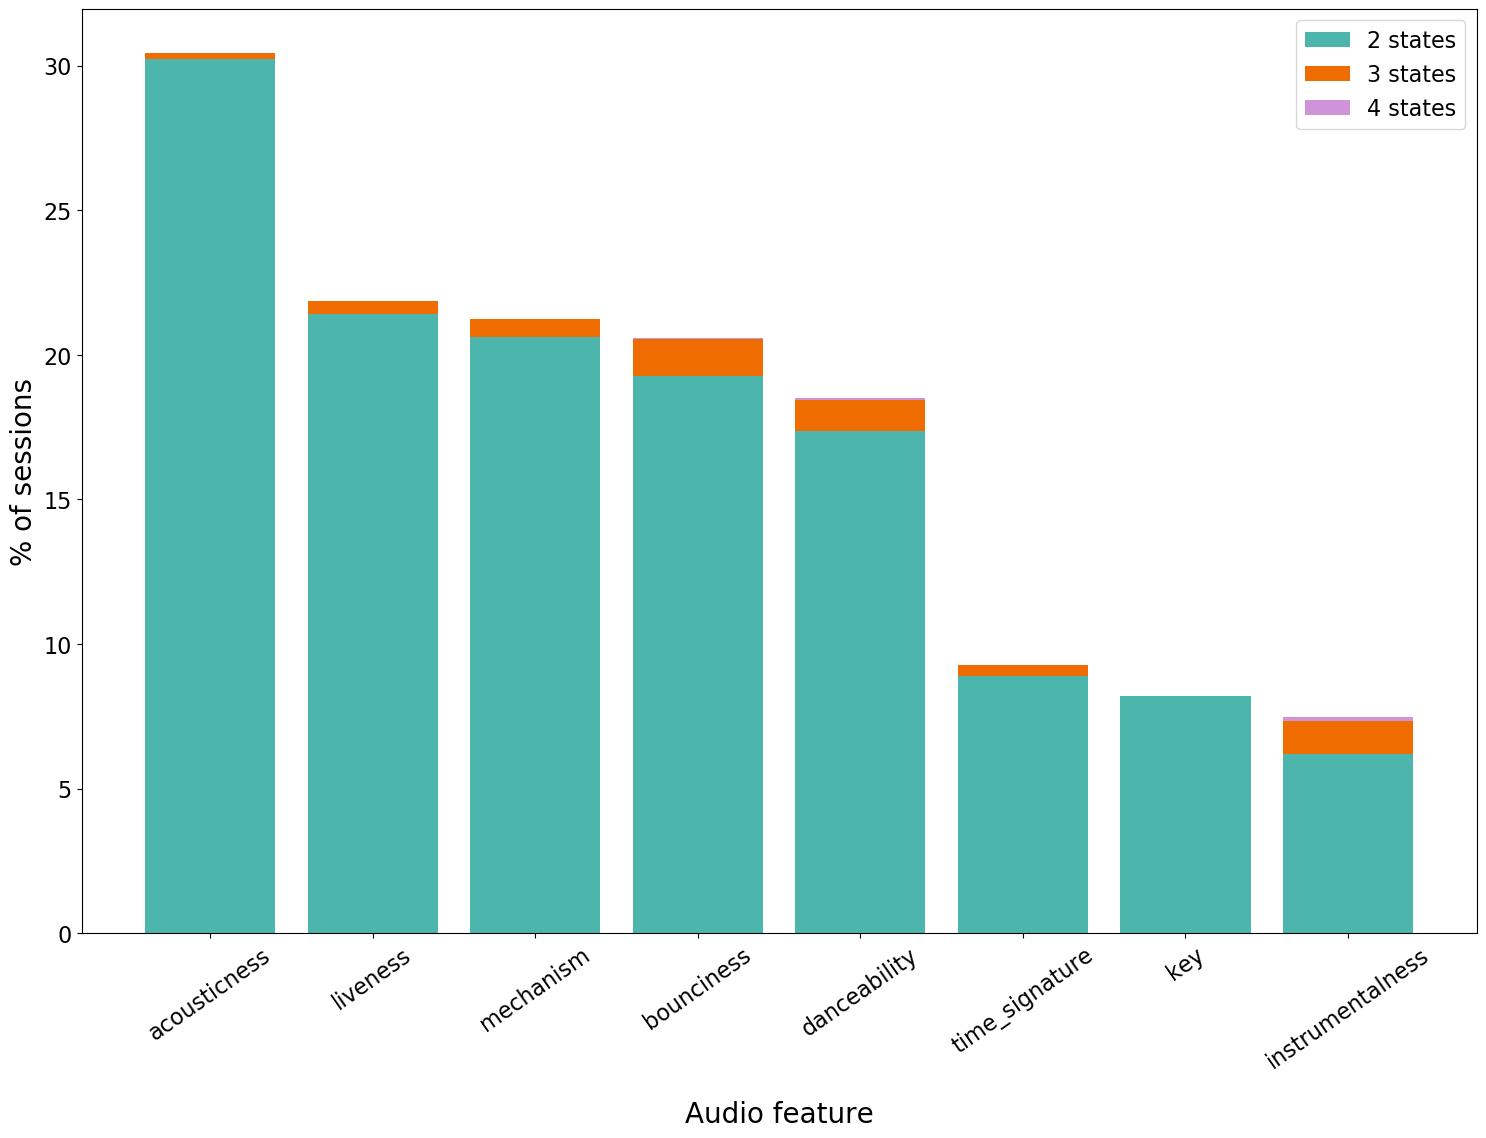

In [70]:
f, ax = plt.subplots(1,1, figsize=(18,12))

cumsum = np.zeros(len(cols_23))
# ax.bar(cols_23, t.loc[1], bottom=cumsum, label='1 state', color='#009668')
# cumsum += t.loc[1]

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

ax.bar(cols_23, t1.loc[2], bottom=cumsum, label='{} states'.format(2), color='#4db6ac')
cumsum += t1.loc[2]
ax.bar(cols_23, t1.loc[3], bottom=cumsum, label='{} states'.format(3), color='#ef6c00')
cumsum += t1.loc[3]
ax.bar(cols_23, t1.loc[4], bottom=cumsum, label='{} states'.format(4), color='#ce93d8')
cumsum += t1.loc[4]
# ax.bar(cols_23, t1.loc[5], bottom=cumsum, label='{} states'.format(5), color='#eeff41')
# cumsum += t1.loc[5]

ax.set_xlabel('Audio feature', labelpad=20)
ax.set_ylabel('% of sessions')
ax.tick_params(axis='x', rotation=35)
# ax.set_ylim([0,100])
plt.legend()
plt.show()

# plt.savefig('3_2_num_states_features.png', dpi=300)

In [68]:
# Percentage of sessions with num_states across outlier features
cols_odd = ['mode','instrumentalness','time_signature']
t = copy.deepcopy(num_states_filt.drop('Total'))
t[audio_cols] = t[audio_cols] / NUM_EXAMPLES * 100
t = t[cols_odd]
# t = t.drop(0)
t.index.name = 'num_states'
# t = t.style.apply(lambda x: highlight_max(x,1)).set_caption('% of sessions with num_states across features')
# t = t.format('{0:,.2f}')
t

mode  instrumentalness  time_signature
num_states                                         
1           48.71             92.51           90.71
2           51.29              6.19            8.90
3            0.00              1.15            0.36
4            0.00              0.15            0.03
5            0.00              0.00            0.00

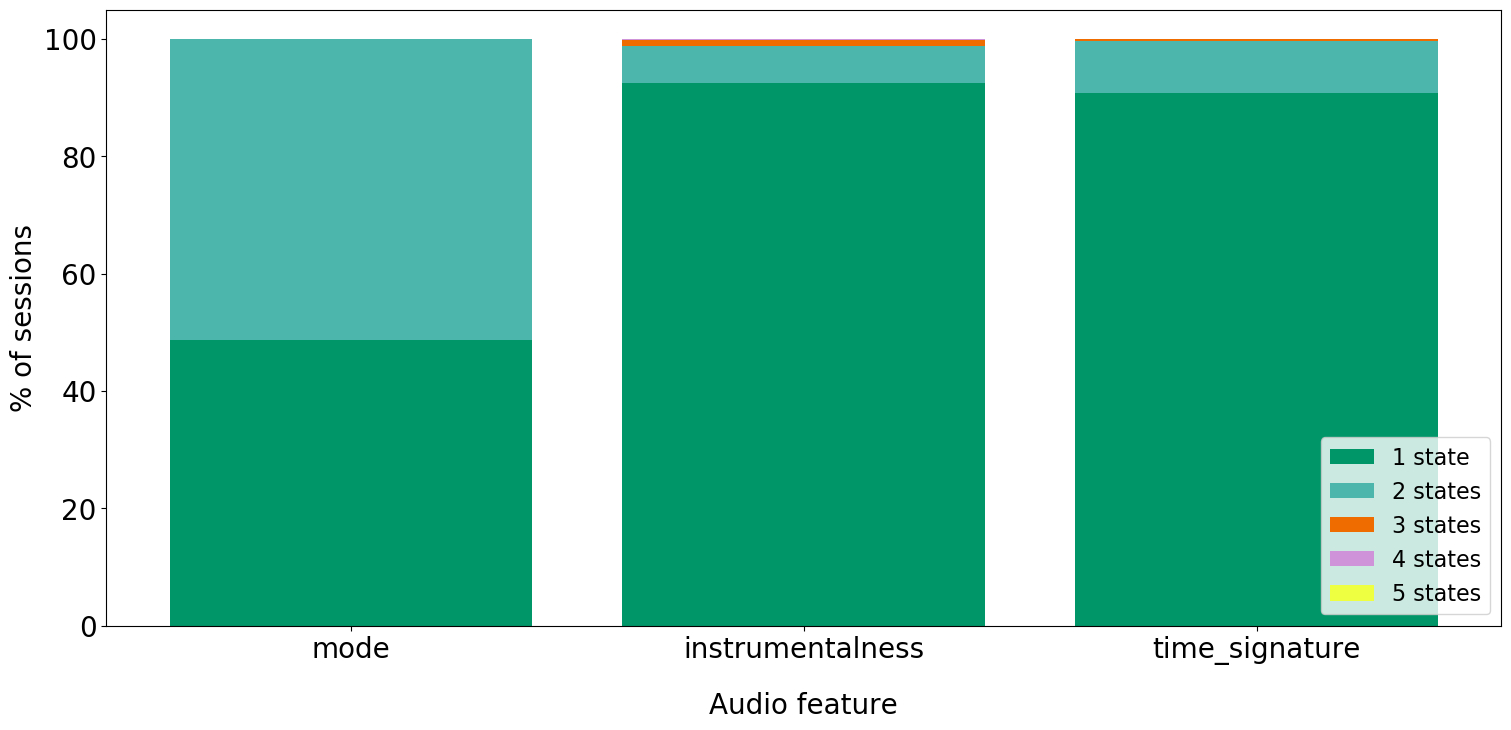

In [69]:
f, ax = plt.subplots(1,1, figsize=(18,8))

cumsum = np.zeros(len(cols_odd))
ax.bar(cols_odd, t.loc[1], bottom=cumsum, label='1 state', color='#009668')
cumsum += t.loc[1]

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

ax.bar(cols_odd, t.loc[2], bottom=cumsum, label='{} states'.format(2), color='#4db6ac')
cumsum += t.loc[2]
ax.bar(cols_odd, t.loc[3], bottom=cumsum, label='{} states'.format(3), color='#ef6c00')
cumsum += t.loc[3]
ax.bar(cols_odd, t.loc[4], bottom=cumsum, label='{} states'.format(4), color='#ce93d8')
cumsum += t.loc[4]
ax.bar(cols_odd, t.loc[5], bottom=cumsum, label='{} states'.format(5), color='#eeff41')
cumsum += t.loc[5]

ax.set_xlabel('Audio feature', labelpad=20)
ax.set_ylabel('% of sessions')
ax.set_ylim([0,105])
plt.legend(loc=4)
plt.show()

# plt.savefig('feat_states_odd.png', dpi=300)

## Sessions meeting criteria: At least 2 states, 3 tracks, no avg skips threshold

In [71]:
# Sessions meeting above criteria
filt = lambda x: match(x, num_states=2, num_tracks=3, threshold=None, return_states=False)
states_filt_bool = states_skips_all.applymap(filt)
states_filt_ids = states_filt_bool[states_filt_bool[states_filt_bool == True].any(axis=1)].index

filt = lambda x: match(x, num_states=2, num_tracks=3, threshold=None, return_states=True, return_matched_states=True)
states_filt = states_skips_all.loc[states_filt_ids].applymap(filt)
states_filt

acousticness      beat_strength  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42               N/A                N/A   
0_000bd318-caf2-4366-ba56-26db623b083d  [[3, 8], [1, 2]]                N/A   
0_00130aaf-66be-4824-be3a-d41f8b8caafb               N/A                N/A   
0_00137cc4-c737-4b01-9e72-1161f3723b72               N/A                N/A   
0_00186766-ee41-49da-8e39-328bbef70f23               N/A                N/A   
...                                                  ...                ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa               N/A  [[1, 4], [1, 13]]   
0_ffe119a4-9b10-4ede-9119-99046d498767               N/A                N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58  [[0, 5], [4, 1]]                N/A   
0_fff3f41f-183a-4664-a623-6db01ab871bc               N/A                N/A   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf  [[9, 1], [7, 1]]                N/A   

                                                       bounciness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           [[3, 7], [3, 2]]   
0_000bd318-caf2-4366-ba56-26db623b083d                        N/A   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                        N/A   
0_00137cc4-c737-4b01-9e72-1161f3723b72                        N/A   
0_00186766-ee41-49da-8e39-328bbef70f23                        N/A   
...                                                           ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [[1, 4], [0, 4], [1, 10]]   
0_ffe119a4-9b10-4ede-9119-99046d498767                        N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                        N/A   
0_fff3f41f-183a-4664-a623-6db01ab871bc                        N/A   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                        N/A   

                                             danceability     dyn_range_mean  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                N/A   [[4, 8], [2, 1]]   
0_000bd318-caf2-4366-ba56-26db623b083d                N/A                N/A   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                N/A                N/A   
0_00137cc4-c737-4b01-9e72-1161f3723b72                N/A                N/A   
0_00186766-ee41-49da-8e39-328bbef70f23                N/A   [[4, 1], [4, 2]]   
...                                                   ...                ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [[1, 4], [1, 14]]  [[1, 6], [1, 12]]   
0_ffe119a4-9b10-4ede-9119-99046d498767                N/A                N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                N/A                N/A   
0_fff3f41f-183a-4664-a623-6db01ab871bc                N/A                N/A   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf   [[9, 2], [7, 0]]                N/A   

                                                          energy  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                       N/A   
0_000bd318-caf2-4366-ba56-26db623b083d                       N/A   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                       N/A   
0_00137cc4-c737-4b01-9e72-1161f3723b72                       N/A   
0_00186766-ee41-49da-8e39-328bbef70f23                       N/A   
...                                                          ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa                       N/A   
0_ffe119a4-9b10-4ede-9119-99046d498767                       N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                       N/A   
0_fff3f41f-183a-4664-a623-6db01ab871bc                       N/A   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf  [[7, 2], [3, 0], [5, 0]]   

                                                 flatness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                N/A   
0_000bd318-caf2-4366-ba56-26db623b083d                N/A   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                N/A   
0_00137cc4-c737-4b01-9e72-1161f3723b72                N/A   
0_00186766-ee41-49da-8e39-328bbef70f23                N/A   
...                                                   ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa                N/A   


In [72]:
# No. of sessions after filtering states
num_states_filt = states_filt.applymap(lambda x: len(x) if isinstance(x, list) else 0) \
                .apply(pd.Series.value_counts).drop(0).fillna(0)

# Total sum per column: 
num_states_filt.loc['Total',:]= num_states_filt.sum(axis=0)

# Total sum per row: 
num_states_filt.loc[:,'Total'] = num_states_filt.sum(axis=1)

num_states_filt

acousticness  beat_strength  bounciness  danceability  dyn_range_mean  \
2            3023.0         1670.0      1927.0        1736.0          2228.0   
3              19.0          100.0       129.0         109.0           147.0   
4               1.0            0.0         1.0           7.0             7.0   
5               0.0            1.0         0.0           0.0             0.0   
Total        3043.0         1771.0      2057.0        1852.0          2382.0   

       energy  flatness  instrumentalness    key  liveness  loudness  \
2      1733.0    1590.0             619.0  820.0    2141.0    1732.0   
3       104.0     192.0             115.0    1.0      46.0     175.0   
4         6.0       6.0              15.0    0.0       0.0       6.0   
5         0.0       0.0               0.0    0.0       0.0       0.0   
Total  1843.0    1788.0             749.0  821.0    2187.0    1913.0   

       mechanism    mode  organism  speechiness   tempo  time_signature  \
2         2063.0  5129.0    1904.0       2862.0  1304.0           890.0   
3           60.0     0.0      55.0        164.0    28.0            36.0   
4            0.0     0.0       4.0          6.0     1.0             3.0   
5            0.0     0.0       0.0          0.0     0.0             0.0   
Total     2123.0  5129.0    1963.0       3032.0  1333.0           929.0   

       valence    Total  
2       1290.0  34661.0  
3         56.0   1536.0  
4          0.0     63.0  
5          0.0      1.0  
Total   1346.0  36261.0

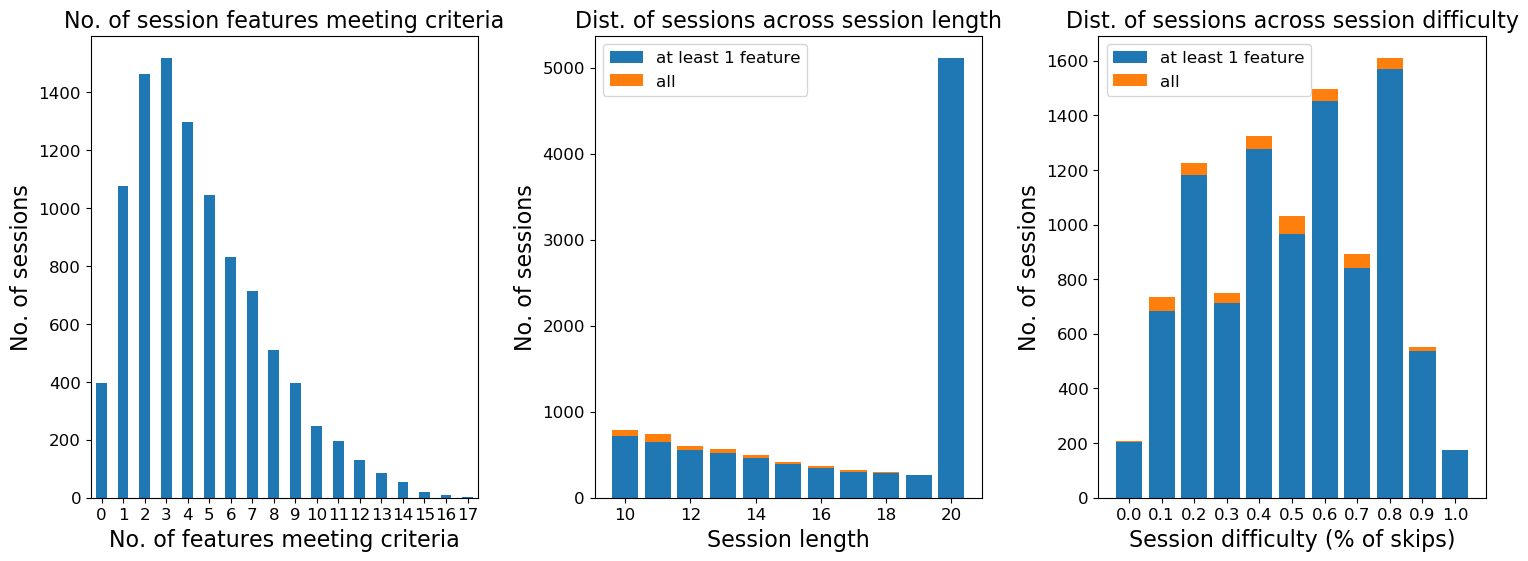

In [89]:
f, ax = plt.subplots(1,3, figsize=(18,6))

plt.rcParams.update(plt.rcParamsDefault)
plt.subplots_adjust(wspace=0.3)
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

tmp = states_filt_bool[states_filt_bool == True].sum(axis=1).value_counts().sort_index()
tmp.index = tmp.index.astype(int)
tmp.plot(ax=ax[0], kind='bar')
ax[0].set_title('No. of session features meeting criteria')
ax[0].set_xlabel('No. of features meeting criteria')
ax[0].set_ylabel('No. of sessions')
ax[0].tick_params(axis='x', rotation=0)

# for x,y in zip(tmp.index, tmp.values):
#     ax[0].annotate(y, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center')

tmp = states_filt_bool[states_filt_bool == True].any(axis=1).reset_index()
tmp = tmp.rename(columns={0:'num'})
tmp['orig'] = True
tmp = tmp.merge(session_data, left_on='index', right_on='session_id').drop(['index','session_id'],axis=1)
tmp = tmp.groupby('session_length').sum()

ax[1].bar(tmp.index, tmp['num'], label='at least 1 feature')
ax[1].bar(tmp.index, tmp['orig'] - tmp['num'], bottom=tmp['num'], label='all')
ax[1].legend()
ax[1].set_title('Dist. of sessions across session length')
ax[1].set_xlabel('Session length')
ax[1].set_ylabel('No. of sessions')

tmp = states_filt_bool[states_filt_bool == True].any(axis=1).reset_index()
tmp = tmp.rename(columns={0:'num'})
tmp['orig'] = True
tmp = tmp.merge(session_data, left_on='index', right_on='session_id').drop(['index','session_id'],axis=1)
tmp['skip_2'] = tmp['skip_2'].round(1)
tmp = tmp.groupby('skip_2').sum()

ax[2].bar(tmp.index*10, tmp['num'], label='at least 1 feature')
ax[2].bar(tmp.index*10, tmp['orig'] - tmp['num'], bottom=tmp['num'], label='all')
ax[2].legend()
ax[2].set_title('Dist. of sessions across session difficulty')
ax[2].set_xlabel('Session difficulty (% of skips)')
ax[2].set_ylabel('No. of sessions')
ax[2].set_xticks(range(0,11))
ax[2].set_xticklabels(tmp.index);
plt.show();

## Sessions meeting criteria: At least 2 states, 3 tracks, avg_skips <= 0.25 or >=0.75

In [90]:
def state_types(states, num_states=2, num_tracks=3, threshold=0.25):
    # At least num_states
    if len(states) < num_states:
        return []

    state_types = []
    for skip_split in states:
        if mapTo0(skip_split, threshold, num_tracks):
            state_types.append(0)
        elif mapTo1(skip_split, threshold, num_tracks):
            state_types.append(1)
        else:
            state_types.append('N/A')
        
    return state_types

In [91]:
# Sessions meeting above criteria
filt = lambda x: state_types(x, num_states=2, num_tracks=3, threshold=0.25)
states_types = states_skips_all.applymap(filt)
states_types

acousticness beat_strength  bounciness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42   [N/A, N/A]            []  [N/A, N/A]   
0_000bd318-caf2-4366-ba56-26db623b083d   [N/A, N/A]            []          []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb           []            []          []   
0_00137cc4-c737-4b01-9e72-1161f3723b72           []            []          []   
0_00186766-ee41-49da-8e39-328bbef70f23           []            []          []   
...                                             ...           ...         ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa           []   [1, N/A, 1]   [1, 1, 1]   
0_ffe119a4-9b10-4ede-9119-99046d498767           []            []          []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58       [1, 0]            []          []   
0_fff3f41f-183a-4664-a623-6db01ab871bc           []            []          []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf       [0, 0]            []          []   

                                       danceability dyn_range_mean  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           []     [N/A, N/A]   
0_000bd318-caf2-4366-ba56-26db623b083d           []             []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb           []             []   
0_00137cc4-c737-4b01-9e72-1161f3723b72           []             []   
0_00186766-ee41-49da-8e39-328bbef70f23           []       [0, N/A]   
...                                             ...            ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa       [1, 1]         [1, 1]   
0_ffe119a4-9b10-4ede-9119-99046d498767           []             []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58           []             []   
0_fff3f41f-183a-4664-a623-6db01ab871bc           []             []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf       [0, 0]             []   

                                                energy flatness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42              []       []   
0_000bd318-caf2-4366-ba56-26db623b083d              []       []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb              []       []   
0_00137cc4-c737-4b01-9e72-1161f3723b72              []       []   
0_00186766-ee41-49da-8e39-328bbef70f23              []       []   
...                                                ...      ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa              []       []   
0_ffe119a4-9b10-4ede-9119-99046d498767              []       []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58              []       []   
0_fff3f41f-183a-4664-a623-6db01ab871bc              []       []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf  [0, N/A, 0, 0]   [0, 0]   

                                       instrumentalness         key  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42    [N/A, N/A, 1]  [N/A, N/A]   
0_000bd318-caf2-4366-ba56-26db623b083d               []          []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb               []          []   
0_00137cc4-c737-4b01-9e72-1161f3723b72               []          []   
0_00186766-ee41-49da-8e39-328bbef70f23               []          []   
...                                                 ...         ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa               []          []   
0_ffe119a4-9b10-4ede-9119-99046d498767               []          []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58               []          []   
0_fff3f41f-183a-4664-a623-6db01ab871bc               []          []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf   [0, N/A, 0, 0]          []   

                                          liveness    loudness   mechanism  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42  [N/A, N/A]  [N/A, N/A]  [N/A, N/A]   
0_000bd318-caf2-4366-ba56-26db623b083d          []          []          []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb          []          []    [N/A, 1]   
0_00137cc4-c737-4b01-9e72-1161f3723b72  [N/A, N/A]          []          []   
0_00186766-ee41-49da-8e39-328bbef70f23          []  [N/A, N/A]          []   
...                                            ...         ...         ...   
0_ffdc370d-59c3-4b71-

In [96]:
# Percentage of states mapping to SAT (avg skips <=0.25) or DSAT (avg skips >= 0.75)
states_types_count = states_types.agg('sum').apply(pd.Series.value_counts).transpose()

# Total sum per column: 
states_types_count.loc['Total',:]= states_types_count.sum(axis=0)
states_types_count = states_types_count / states_types_count.loc['Total'] * 100
states_types_count.drop('Total', inplace=True)
states_types_count.index = ['N/A', 'DSAT', 'SAT']
# states_types_count = states_types_count[selected_cols]
# states_types_count = states_types_count.style.format('{0:,.2f}')
# states_types_count.set_caption('% of SAT states (avg skips <=0.25) or DSAT states (avg skips >= 0.75)')
states_types_count

acousticness  beat_strength  bounciness  danceability  dyn_range_mean  \
N/A      50.546448      52.548821   51.771824     51.501430       52.181115   
DSAT     25.913144      25.919351   27.225583     26.954242       27.369777   
SAT      23.540408      21.531829   21.002593     21.544328       20.449107   

         energy   flatness  instrumentalness        key   liveness   loudness  \
N/A   51.659554  54.159007         70.975014  50.000000  56.602241  52.806736   
DSAT  25.391181  24.931066         13.714071  27.413588  24.200097  23.997594   
SAT   22.949265  20.909926         15.310915  22.586412  19.197661  23.195670   

      mechanism       mode   organism  speechiness      tempo  time_signature  \
N/A   49.902323  50.598747  50.757924    52.929954  51.102555       74.754477   
DSAT  27.588452  30.167649  27.124483    26.873808  26.286314       12.969382   
SAT   22.509225  19.233604  22.117593    20.196239  22.611131       12.276141   

        valence  
N/A   51.330150  
DSAT  26.534789  
SAT   22.135061

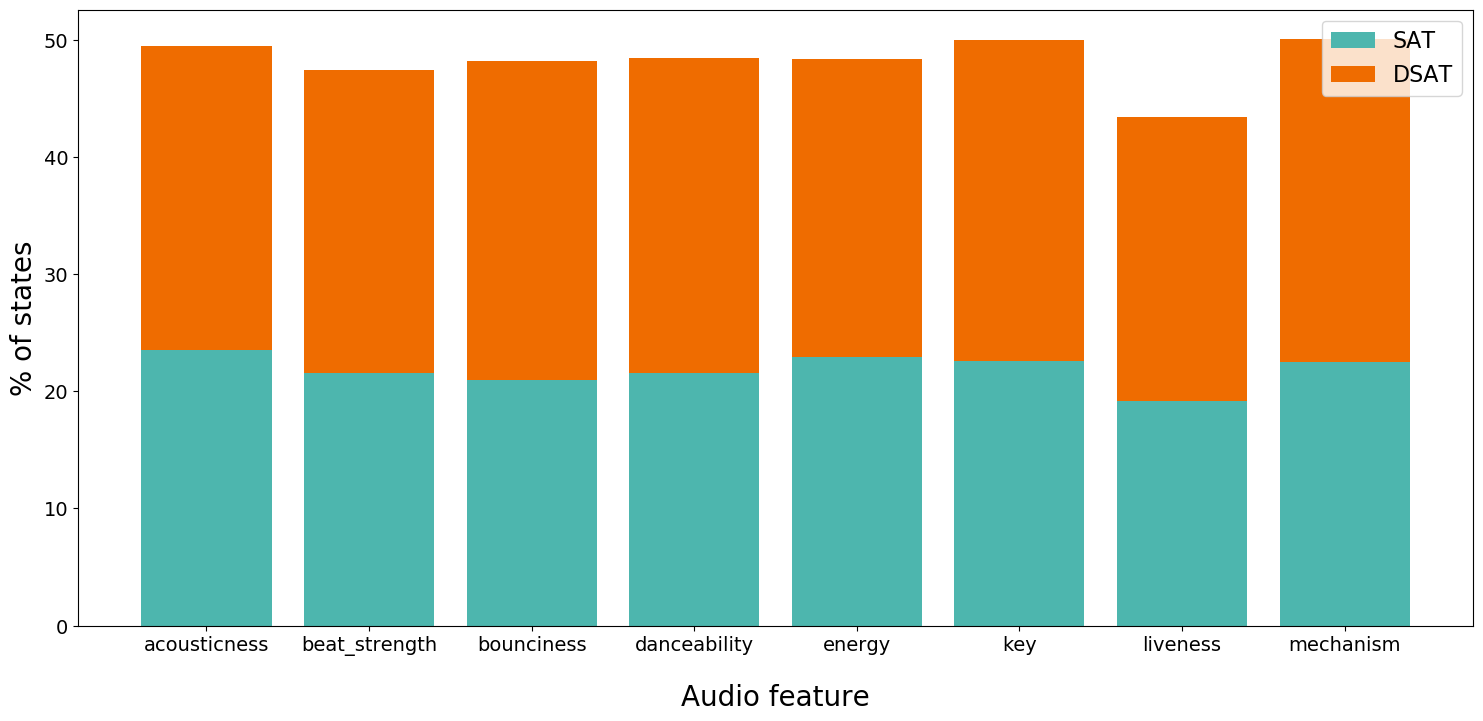

In [100]:
colsT=['acousticness','beat_strength','bounciness','danceability','energy','key','liveness','mechanism']
t = states_types_count[colsT].iloc[1:]

f, ax = plt.subplots(1,1, figsize=(18,8))

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

cumsum = np.zeros(len(colsT))
ax.bar(colsT, t.loc['SAT'], bottom=cumsum, label='SAT', color='#4db6ae')
cumsum += t.loc['SAT']
ax.bar(colsT, t.loc['DSAT'], bottom=cumsum, label='DSAT', color='#ef6c00')

ax.set_xlabel('Audio feature', labelpad=20)
ax.set_ylabel('% of states')
plt.legend()
ax.tick_params(axis='x', rotation=0)

plt.show()
# plt.savefig('sat_dsat_states.png', dpi=300)

In [101]:
# Sessions meeting above criteria
filt = lambda x: match(x, num_states=2, num_tracks=3, threshold=0.25, return_states=False)
states_filt_thres_bool = states_skips_all.applymap(filt)
states_filt_thres_ids = states_filt_thres_bool[states_filt_thres_bool[states_filt_thres_bool == True].any(axis=1)].index

filt = lambda x: match(x, num_states=2, num_tracks=3, threshold=0.25, return_states=True, return_matched_states=True)
states_filt_thres = states_skips_all.loc[states_filt_thres_ids].applymap(filt)
states_filt_thres

acousticness  \
0_01368ea5-b922-4d7e-96a8-9b37913ebbfc               N/A   
0_027acf99-69c8-4266-bebb-918fa5d6c5c8               N/A   
0_02ccd200-b4fe-437a-bbf9-8c12fa0b67f5               N/A   
0_035a331c-c21b-4dd0-9e55-46b5c30245a7               N/A   
0_0384686c-53dc-450a-9e33-b9eb6f78b7e5               N/A   
...                                                  ...   
0_fb8f83ca-3515-4631-b8da-fb45ec009c40             False   
0_fbcd05d5-93f2-4aff-8b7d-f947ed70e906             False   
0_fc18ba1f-99b8-4016-913b-249a83d989c3             False   
0_fec24504-0871-4fc6-8490-cfd142da5978               N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58  [[0, 5], [4, 1]]   

                                                   beat_strength  \
0_01368ea5-b922-4d7e-96a8-9b37913ebbfc                       N/A   
0_027acf99-69c8-4266-bebb-918fa5d6c5c8                       N/A   
0_02ccd200-b4fe-437a-bbf9-8c12fa0b67f5                     False   
0_035a331c-c21b-4dd0-9e55-46b5c30245a7                       N/A   
0_0384686c-53dc-450a-9e33-b9eb6f78b7e5                       N/A   
...                                                          ...   
0_fb8f83ca-3515-4631-b8da-fb45ec009c40                       N/A   
0_fbcd05d5-93f2-4aff-8b7d-f947ed70e906  [[1, 3], [5, 0], [0, 4]]   
0_fc18ba1f-99b8-4016-913b-249a83d989c3                       N/A   
0_fec24504-0871-4fc6-8490-cfd142da5978                       N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                       N/A   

                                                      bounciness  \
0_01368ea5-b922-4d7e-96a8-9b37913ebbfc                     False   
0_027acf99-69c8-4266-bebb-918fa5d6c5c8                       N/A   
0_02ccd200-b4fe-437a-bbf9-8c12fa0b67f5                     False   
0_035a331c-c21b-4dd0-9e55-46b5c30245a7                       N/A   
0_0384686c-53dc-450a-9e33-b9eb6f78b7e5                       N/A   
...                                                          ...   
0_fb8f83ca-3515-4631-b8da-fb45ec009c40                     False   
0_fbcd05d5-93f2-4aff-8b7d-f947ed70e906  [[1, 3], [4, 0], [1, 4]]   
0_fc18ba1f-99b8-4016-913b-249a83d989c3                       N/A   
0_fec24504-0871-4fc6-8490-cfd142da5978                       N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                       N/A   

                                            danceability     dyn_range_mean  \
0_01368ea5-b922-4d7e-96a8-9b37913ebbfc               N/A              False   
0_027acf99-69c8-4266-bebb-918fa5d6c5c8               N/A                N/A   
0_02ccd200-b4fe-437a-bbf9-8c12fa0b67f5             False              False   
0_035a331c-c21b-4dd0-9e55-46b5c30245a7               N/A                N/A   
0_0384686c-53dc-450a-9e33-b9eb6f78b7e5               N/A                N/A   
...                                                  ...                ...   
0_fb8f83ca-3515-4631-b8da-fb45ec009c40             False  [[13, 2], [1, 4]]   
0_fbcd05d5-93f2-4aff-8b7d-f947ed70e906  [[4, 1], [1, 4]]              False   
0_fc18ba1f-99b8-4016-913b-249a83d989c3               N/A                N/A   
0_fec24504-0871-4fc6-8490-cfd142da5978               N/A                N/A   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58               N/A                N/A   

                                                  energy          flatness  \
0_01368ea5-b922-4d7e-96a8-9b37913ebbfc               N/A  [[1, 3], [3, 1]]   
0_027acf99-69c8-4266-bebb-918fa5d6c5c8               N/A               N/A   
0_02ccd200-b4fe-437a-bbf9-8c12fa0b67f5               N/A               N/A   
0_035a331c-c21b-4dd0-9e55-46b5c30245a7               N/A  [[6, 2], [1, 3]]   
0_0384686c-53dc-450a-9e33-b9eb6f78b7e5               N/A               N/A   
...                                                  ...               ...   
0_fb8f83ca-3515-4631-b8da-fb45ec009c40             False               N/A   
0_fbcd05d5-93f2-4aff-8b7d-f947ed70e906             False             False   
0_fc18ba1f-99b8-4016-913b-249a83d989c3

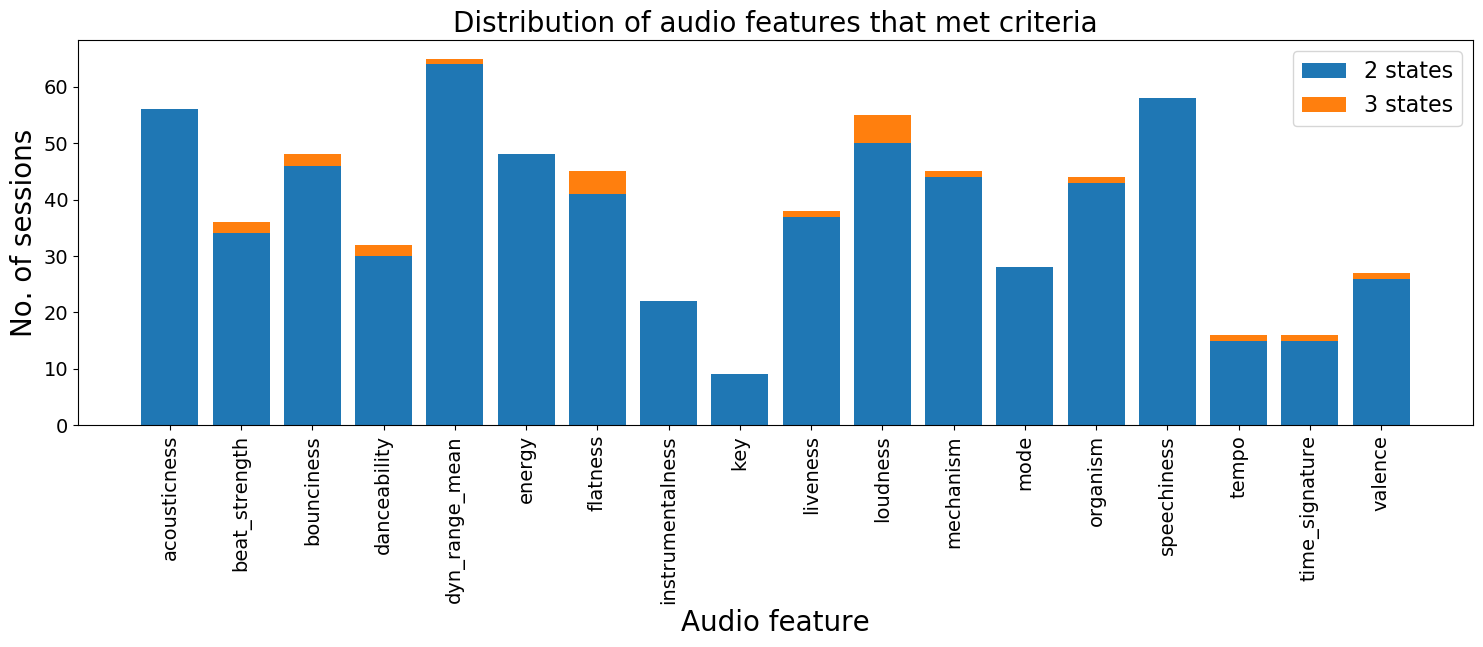

In [107]:
stacked_counts = states_filt_thres.applymap(lambda x: len(x) if isinstance(x, list) else 0) \
                .apply(pd.Series.value_counts).drop(0).fillna(0)

f, ax = plt.subplots(1,1, figsize=(18,5))

cumsum = np.zeros(len(audio_cols))
for i in stacked_counts.index:
    ax.bar(audio_cols, stacked_counts.loc[i], bottom=cumsum, label='{} states'.format(i))
    cumsum += stacked_counts.loc[i]

ax.set_title('Distribution of audio features that met criteria')
ax.set_xlabel('Audio feature')
ax.set_ylabel('No. of sessions')
plt.legend()
ax.tick_params(axis='x', rotation=90)
plt.show()

## No. of sessions with N features that have ≥2 states

In [109]:
most_probable_means = np.array([[means[state] for state in states] for states,means in zip(most_probable_states_merged,truncate(means))])
most_probable_means

array([[0.11, 0.11, 0.11, ..., 0.6 , 0.6 , 0.6 ],
       [0.12, 0.12, 0.12, ..., 0.12, 0.12, 0.12],
       [0.06, 0.06, 0.06, ..., 0.06, 0.06, 0.06],
       ...,
       [0.37, 0.37, 0.37, ..., 0.37, 0.37, 0.37],
       [0.66, 0.66, 0.66, ..., 0.66, 0.66, 0.66],
       [0.33, 0.33, 0.33, ..., 0.33, 0.33, 0.33]])

In [110]:
# Replace each state of each audio attribute with the latent mean
sess_data = sampled_data[['session_id','session_position','skip_2','session_length']]
sess_data['skip_2'] = sess_data['skip_2'].astype(int)
sess_data.reset_index(drop=True, inplace=True)

sess_lengths = sampled_data.groupby('session_id').count()['session_length'].values
sess_lengths = np.array([sess_lengths for i in range(len(audio_cols))]).flatten()

sess_transitions = [most_probable_means[idx][:length] for idx, length in enumerate(sess_lengths)]
sess_transitions = [np.concatenate(sess_transitions[i * NUM_EXAMPLES:(i+1) * NUM_EXAMPLES]) for i in range(len(audio_cols))]
sess_transitions = pd.DataFrame(np.array(sess_transitions).transpose(), columns=audio_cols)

sess_transitions = pd.concat([sess_data,sess_transitions], axis=1)
# sess_transitions = sess_transitions[sess_transitions['session_id'].isin(sess_ids.sample(10000))]
sess_transitions

/Users/aaronng/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


session_id  session_position  skip_2  \
0       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 1       1   
1       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 2       1   
2       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 3       0   
3       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 4       1   
4       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 5       1   
...                                        ...               ...     ...   
168257  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                14       0   
168258  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                15       0   
168259  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                16       0   
168260  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                17       0   
168261  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                18       0   

        session_length  acousticness  beat_strength  bounciness  danceability  \
0                   15          0.11           0.52        0.50          0.62   
1                   15          0.11           0.52        0.50          0.62   
2                   15          0.11           0.52        0.50          0.62   
3                   15          0.11           0.52        0.50          0.62   
4                   15          0.11           0.52        0.50          0.62   
...                ...           ...            ...         ...           ...   
168257              18          0.70           0.31        0.29          0.37   
168258              18          0.24           0.31        0.29          0.51   
168259              18          0.70           0.31        0.29          0.37   
168260              18          0.70           0.31        0.29          0.37   
168261              18          0.70           0.31        0.29          0.37   

        dyn_range_mean  energy  flatness  instrumentalness   key  liveness  \
0                 0.20    0.74      0.88              0.73  0.60      0.13   
1                 0.20    0.74      0.88              0.73  0.60      0.13   
2                 0.20    0.74      0.88              0.02  0.60      0.13   
3                 0.20    0.74      0.88              0.42  0.37      0.38   
4                 0.20    0.74      0.88              0.73  0.37      0.13   
...                ...     ...       ...               ...   ...       ...   
168257            0.14    0.33      0.90              0.45  0.37      0.13   
168258            0.14    0.72      0.83              0.05  0.37      0.13   
168259            0.14    0.33      0.90              0.45  0.37      0.13   
168260            0.14    0.33      0.90              0.74  0.37      0.13   
168261            0.14    0.33      0.90              0.05  0.37      0.13   

        loudness  mechanism  mode  organism  speechiness  tempo  \
0           0.88       0.80  0.50      0.17         0.08   0.51   
1           0.88       0.80  0.49      0.17         0.08   0.51   
2           0.88       0.80  0.49      0.17         0.08   0.51   
3           0.88       0.80  0.50      0.17         0.08   0.51   
4           0.88       0.80  0.50      0.17         0.08   0.51   
...          ...        ...   ...       ...          ...    ...   
168257      0.77       0.34  0.51      0.65         0.05   0.45   
168258      0.78       0.60  0.51      0.33         0.05   0.45   
168259      0.78       0.34  0.51      0.65         0.05   0.45   
168260      0.77       0.34  0.51      0.65         0.05   0.45   
168261      0.77       0.34  0.51      0.65         0.05   0.45   

        time_signature  valence  
0                 0.79     0.71  
1                 0.79     0.44  
2                 0.79     0.71  
3                 0.79     0.71  
4                 0.79     0.44  
...                ...      ...  
168257            0.78     0.33  
168258            0.78     0.33  
168259            0.63     0.33  
168260            0.63     0.33  
168261            0.78     0.33  


In [112]:
# No. of features with N states across all sessions
sess_num_states = sess_transitions.groupby('session_id').nunique()[audio_cols]\
.transpose().apply(pd.Series.value_counts)
sess_num_states.loc['>=4'] = sess_num_states.loc[4:].sum()
sess_num_states.drop([4,5,6], inplace=True)
sess_num_states

session_id  0_00074d75-33c6-40b3-99e1-a88e9d015e42  \
1                                              4.0   
2                                             12.0   
3                                              2.0   
>=4                                            0.0   

session_id  0_000bd318-caf2-4366-ba56-26db623b083d  \
1                                             17.0   
2                                              1.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_00130aaf-66be-4824-be3a-d41f8b8caafb  \
1                                             14.0   
2                                              3.0   
3                                              1.0   
>=4                                            0.0   

session_id  0_00137cc4-c737-4b01-9e72-1161f3723b72  \
1                                             16.0   
2                                              2.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_00186766-ee41-49da-8e39-328bbef70f23  \
1                                             15.0   
2                                              3.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_001a5ce4-4ab7-4508-861b-56c6e40426b9  \
1                                             17.0   
2                                              1.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_0029d467-d1c5-4a83-8385-8ce0f8897b26  \
1                                             13.0   
2                                              4.0   
3                                              1.0   
>=4                                            0.0   

session_id  0_002c8e3a-7201-4d8d-b614-5d5d2e417e60  \
1                                             13.0   
2                                              5.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_0032b965-74d5-49e9-8272-7b5948320e6e  \
1                                             11.0   
2                                              7.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_00330c55-d1d7-427c-af10-52cb1b6b0361  \
1                                             16.0   
2                                              2.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_00418ca0-48fe-45d1-a5aa-4df0c9b051bd  \
1                                             15.0   
2                                              3.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_0050a5c3-cf69-4c27-939d-7a3363063b1e  \
1                                             15.0   
2                                              3.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_00529630-d19f-4c57-8418-298976de74b1  \
1                                             13.0   
2                                              5.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_0053873b-58f3-4bd7-83ac-b549498b7e0e  \
1                                             12.0   
2                                              6.0   
3                                              NaN   
>=4                                            0.0   

session_id  0_00554df7-96ba-460d-bcce-19270782e592  \
1                                             13.0   
2                                              4.0   
3                                           

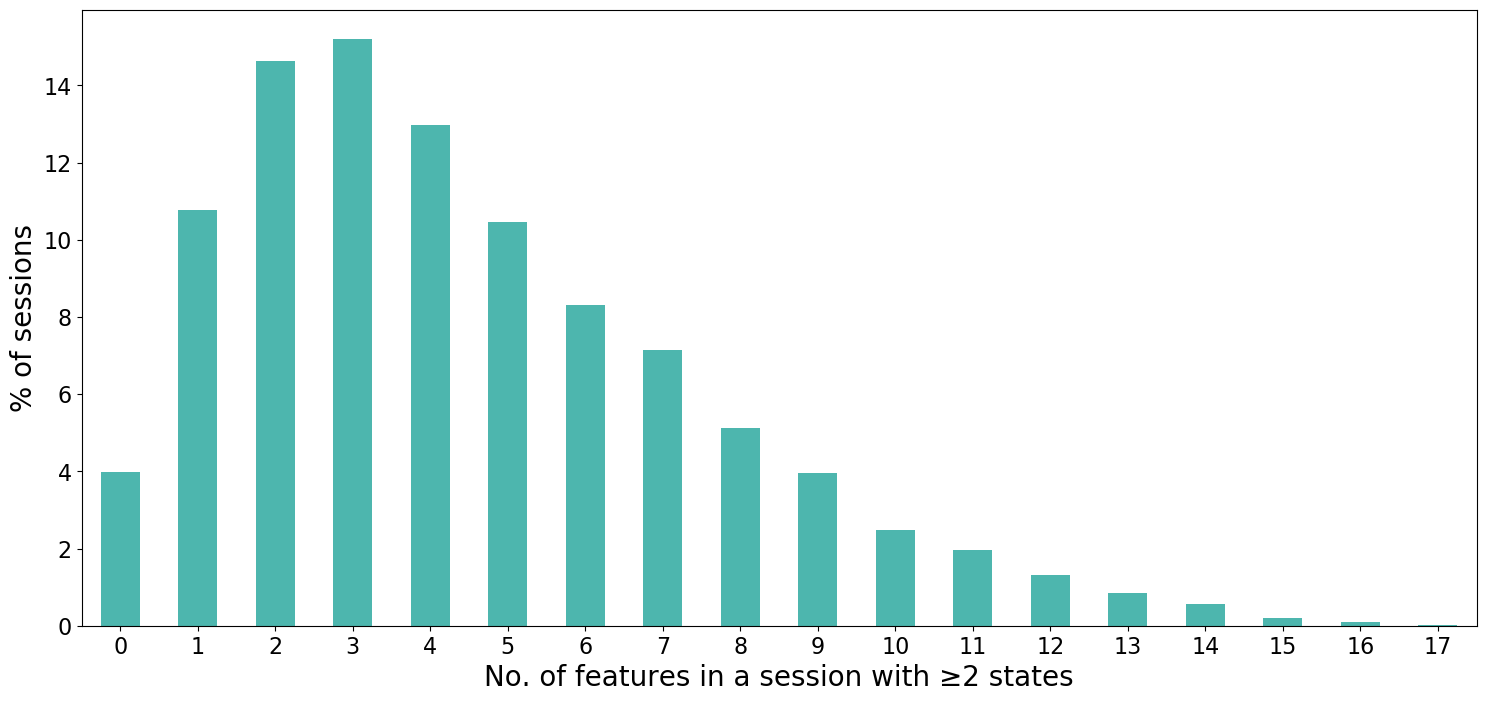

In [126]:
# Plot distribution of sessions with N features that have ≥2 states

two_ormore_states = sess_num_states.iloc[1:].sum().value_counts().sort_index() / NUM_EXAMPLES * 100
# two_ormore_states = sess_num_states.iloc[1:].sum().value_counts().sort_index() / NUM_EXAMPLES * 100
# three_ormore_states = sess_num_states.iloc[2:].sum().value_counts().sort_index() / NUM_EXAMPLES * 100
# four_ormore_states = sess_num_states.iloc[3:].sum().value_counts().sort_index() / NUM_EXAMPLES * 100

t2 = pd.DataFrame(two_ormore_states, columns=['≥2 states'])
# t = t.merge(pd.DataFrame(three_ormore_states, columns=['≥3 states']), left_index=True, right_index=True, how='outer')
# t = t.merge(pd.DataFrame(four_ormore_states, columns=['≥4 states']), left_index=True, right_index=True, how='outer')
t2 = t2.fillna(0)
t2.index = t2.index.astype(int)

f, ax = plt.subplots(1,1, figsize=(18,8))
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

ax.set_ylabel('% of sessions')
ax.set_xlabel('No. of features in a session with ≥2 states')
ax.set_xticks(range(0,25))
t2.plot(kind='bar', ax=ax, color='#4db6ae', legend=None)
ax.set_xticklabels(t2.index)
ax.tick_params(axis='x', rotation=0);
plt.show()
# plt.savefig('two_states_dist.png', dpi=300)

## Feature Correlation

In [114]:
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
import seaborn as sns

In [117]:
unique_tracks = sampled_data[['track_id'] + audio_cols].groupby('track_id').mean()

pearson_matrix = np.zeros((len(audio_cols),len(audio_cols)))
spearman_matrix = np.zeros((len(audio_cols),len(audio_cols)))

for i in range(len(audio_cols)):
    for j in range(i,len(audio_cols)):
        pearson_matrix[i][j] = pearsonr(unique_tracks[audio_cols[i]], unique_tracks[audio_cols[j]])[0]
        spearman_matrix[i][j] = spearmanr(unique_tracks[audio_cols[i]], unique_tracks[audio_cols[j]])[0]

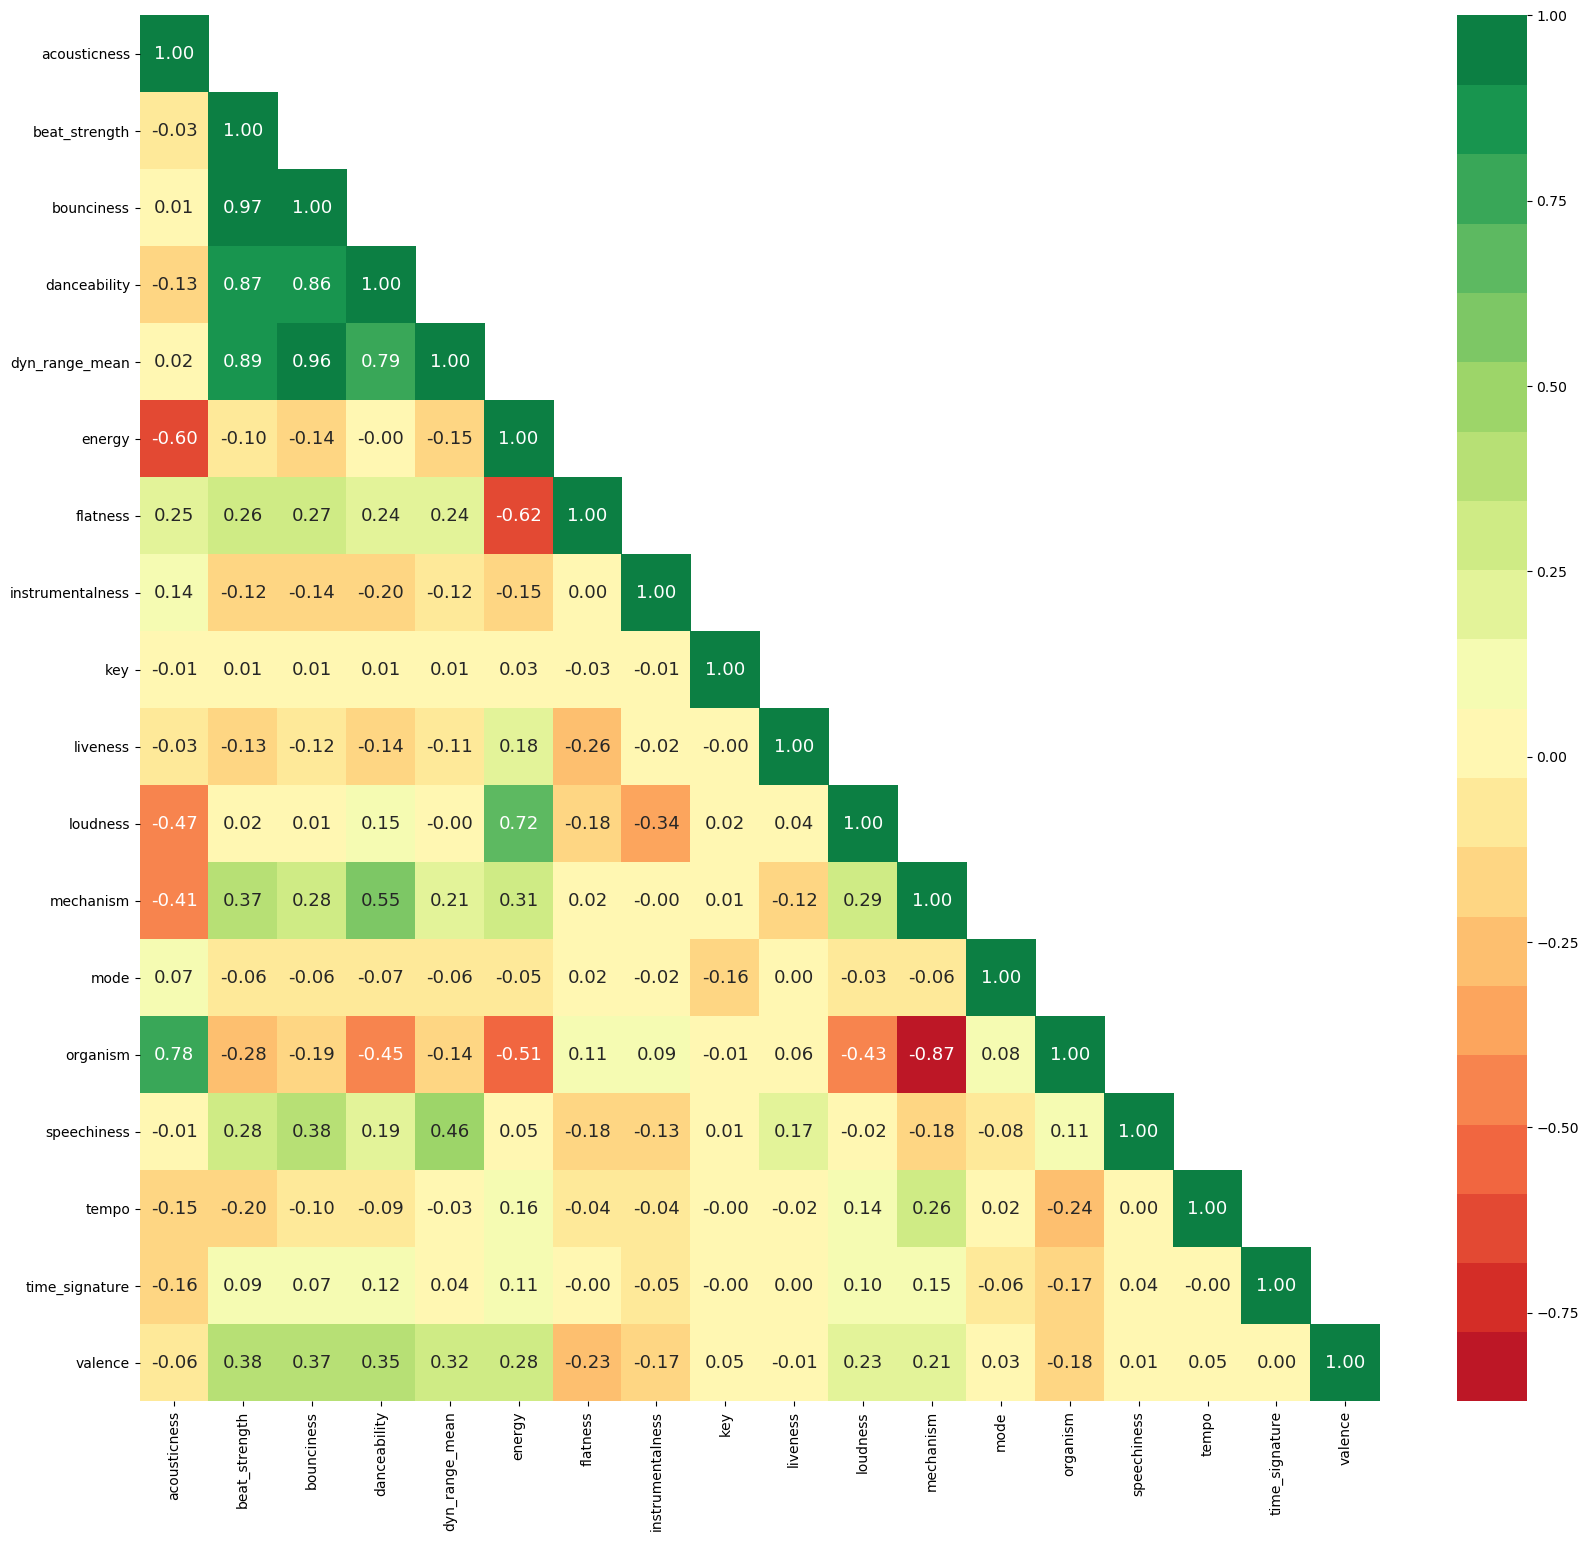

In [123]:
t = copy.deepcopy(pearson_matrix)
t[t==0] = np.nan
t = t.transpose()

plt.rcParams.update(plt.rcParamsDefault)
f, ax = plt.subplots(1, 1, figsize=(20,18))
ax.set_facecolor('white')
# sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(t, columns=audio_cols, index=audio_cols), ax=ax, annot=True, fmt=".2f",
            annot_kws={"size":13},
            cmap=sns.color_palette("RdYlGn", n_colors=20)
#             cbar_kws=dict(use_gridspec=False,location="top")
           )
plt.show()
# plt.savefig('correlation_confusion_matrix.png')

## State transitions and correlation with skip/non-skip transitions

In [ ]:
# Replace states by their respective avg_skips and use that as a score to rank tracks later
sess_feat_scores = []
sess_feat_states = []

for i, (sess_states_padded,sess_means_padded) in enumerate(zip(most_probable_states_merged,means)):
    idx = i % NUM_EXAMPLES
    sess_states_i = sess_states_padded[:session_lengths[idx]]

    session = pd.DataFrame(sess_states_i, columns=['states'])
    session['skip_2'] = observed_skips[idx][:session_lengths[idx]]
    
    states_avg_skips_dict = session.groupby('states').agg(lambda x: np.sum(x) / len(x)).to_dict('index')
    sess_feat_score = [states_avg_skips_dict[state]['skip_2'] for state in sess_states_i]

    sess_feat_scores.append(sess_feat_score)
    sess_feat_states.append(sess_states_i)
    
    if i%1000 == 0:
        print('Processed {} sequences'.format(i))

In [128]:
# States for each track in each audio attribute for all sessions
sess_states = np.array([np.array(x) for x in sess_feat_states]).reshape(len(audio_cols), NUM_EXAMPLES)
sess_states = [np.hstack(feat) for feat in sess_states]
sess_states = pd.DataFrame(np.array(sess_states).transpose(), columns=audio_cols)

sess_states[['session_id','session_position','skip_2']] = sampled_data[['session_id','session_position','skip_2']]
sess_states = sess_states[['session_id','session_position','skip_2'] + audio_cols]
sess_states['skip_2'] = sess_states['skip_2'].astype(int)
sess_states['relevance'] = sess_states['skip_2'] ^ 1
sess_states.drop('skip_2',axis=1,inplace=True)

sess_states

session_id  session_position  \
0       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 1   
1       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 2   
2       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 3   
3       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 4   
4       0_00074d75-33c6-40b3-99e1-a88e9d015e42                 5   
...                                        ...               ...   
168257  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                14   
168258  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                15   
168259  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                16   
168260  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                17   
168261  0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                18   

        acousticness  beat_strength  bounciness  danceability  dyn_range_mean  \
0                  0              0           1             0               1   
1                  0              0           1             0               1   
2                  0              0           1             0               1   
3                  0              0           1             0               1   
4                  0              0           1             0               1   
...              ...            ...         ...           ...             ...   
168257             3              0           0             0               0   
168258             0              0           0             6               0   
168259             3              0           0             0               0   
168260             3              0           0             0               0   
168261             3              0           0             0               0   

        energy  flatness  instrumentalness  key  liveness  loudness  \
0            0         0                 5    0         0         0   
1            0         0                 5    0         0         0   
2            0         0                 9    0         0         0   
3            0         0                 0    1         8         0   
4            0         0                 5    1         0         0   
...        ...       ...               ...  ...       ...       ...   
168257       0         0                 8    0         0         0   
168258       1         1                 0    0         0         3   
168259       0         0                 8    0         0         3   
168260       0         0                 5    0         0         0   
168261       0         0                 0    0         0         0   

        mechanism  mode  organism  speechiness  tempo  time_signature  \
0               0     3         0            0      0               0   
1               0     0         0            0      0               0   
2               0     0         0            0      0               0   
3               0     3         0            0      0               0   
4               0     3         0            0      0               0   
...           ...   ...       ...          ...    ...             ...   
168257          0     0         0            0      0               0   
168258          8     0         4            0      0               0   
168259          0     0         0            0      0               7   
168260          0     0         0            0      0               7   
168261          0     0         0            0      0               0   

        valence  relevance  
0             8          0  
1             0          0  
2             8          1  
3             8          0  
4             0          0  
...         ...        ...  
168257        0          1  
168258        0          1  
168259        0          1  
168260        0          1  
168261        0          1  

[168262 rows x 21 columns]

In [ ]:
rel_transitions = []

for i, sess_id in enumerate(sess_states['session_id'].unique()):
    session = sess_states[sess_states['session_id'] == sess_id]
#     print(session)
    sess_rel_transitions = []
    
    for audio_col in audio_cols:
        sess_feat = list(session[audio_col])
        sess_feat_transition_idx = [i for i in range(1,len(sess_feat)) if sess_feat[i]!=sess_feat[i-1]]

        sess_feat_rel_transitions = []
        for idx in sess_feat_transition_idx:
            rel = list(session['relevance'])[idx-1:idx+1]
            if rel[0] != rel[1]:
                sess_feat_rel_transitions.append(1)
            else:
                sess_feat_rel_transitions.append(0)
        sess_rel_transitions.append(sess_feat_rel_transitions)
        
    rel_transitions.append(sess_rel_transitions)
    
    if i%100 == 0:
        print('Processed {} sessions'.format(i))

In [132]:
# List of all transitions for each audio attribute 
# 1 = transition correlated with skip/non-skip transition, 0 = no transition in skip/non-skip between tracks

rel_transitions_all = pd.DataFrame(
    rel_transitions, 
    columns=audio_cols, 
    index=sampled_data['session_id'].unique()
)
rel_transitions_all

acousticness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                                [0]   
0_000bd318-caf2-4366-ba56-26db623b083d                 [0, 0, 0, 1, 0, 0]   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                                 []   
0_00137cc4-c737-4b01-9e72-1161f3723b72                                 []   
0_00186766-ee41-49da-8e39-328bbef70f23                                 []   
...                                                                   ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa                                 []   
0_ffe119a4-9b10-4ede-9119-99046d498767                                 []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                       [1, 0, 0, 1]   
0_fff3f41f-183a-4664-a623-6db01ab871bc                                 []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]   

                                                               beat_strength  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                                    []   
0_000bd318-caf2-4366-ba56-26db623b083d                                    []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                                    []   
0_00137cc4-c737-4b01-9e72-1161f3723b72                                    []   
0_00186766-ee41-49da-8e39-328bbef70f23                                    []   
...                                                                      ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]   
0_ffe119a4-9b10-4ede-9119-99046d498767                                    []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                                    []   
0_fff3f41f-183a-4664-a623-6db01ab871bc                                    []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                                    []   

                                                                        bounciness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                                   [0, 1, 0]   
0_000bd318-caf2-4366-ba56-26db623b083d                                          []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                                          []   
0_00137cc4-c737-4b01-9e72-1161f3723b72                                          []   
0_00186766-ee41-49da-8e39-328bbef70f23                                          []   
...                                                                            ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
0_ffe119a4-9b10-4ede-9119-99046d498767                                          []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                                          []   
0_fff3f41f-183a-4664-a623-6db01ab871bc                                          []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                                          []   

                                                          danceability  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                              []   
0_000bd318-caf2-4366-ba56-26db623b083d                              []   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                              []   
0_00137cc4-c737-4b01-9e72-1161f3723b72                              []   
0_00186766-ee41-49da-8e39-328bbef70f23                              []   
...                                                                ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]   
0_ffe119a4-9b10-4ede-9119-99046d498767                              []   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                              []   
0_fff3f41f-183a-4664-a623-6db01ab871bc                              []   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                 [1, 0, 0, 0, 0]   

                                                              dyn_range_mean  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                                   [0]   
0_000bd318-caf2-4366-ba56-26db623b083d                                    []   
0_00130aaf-66

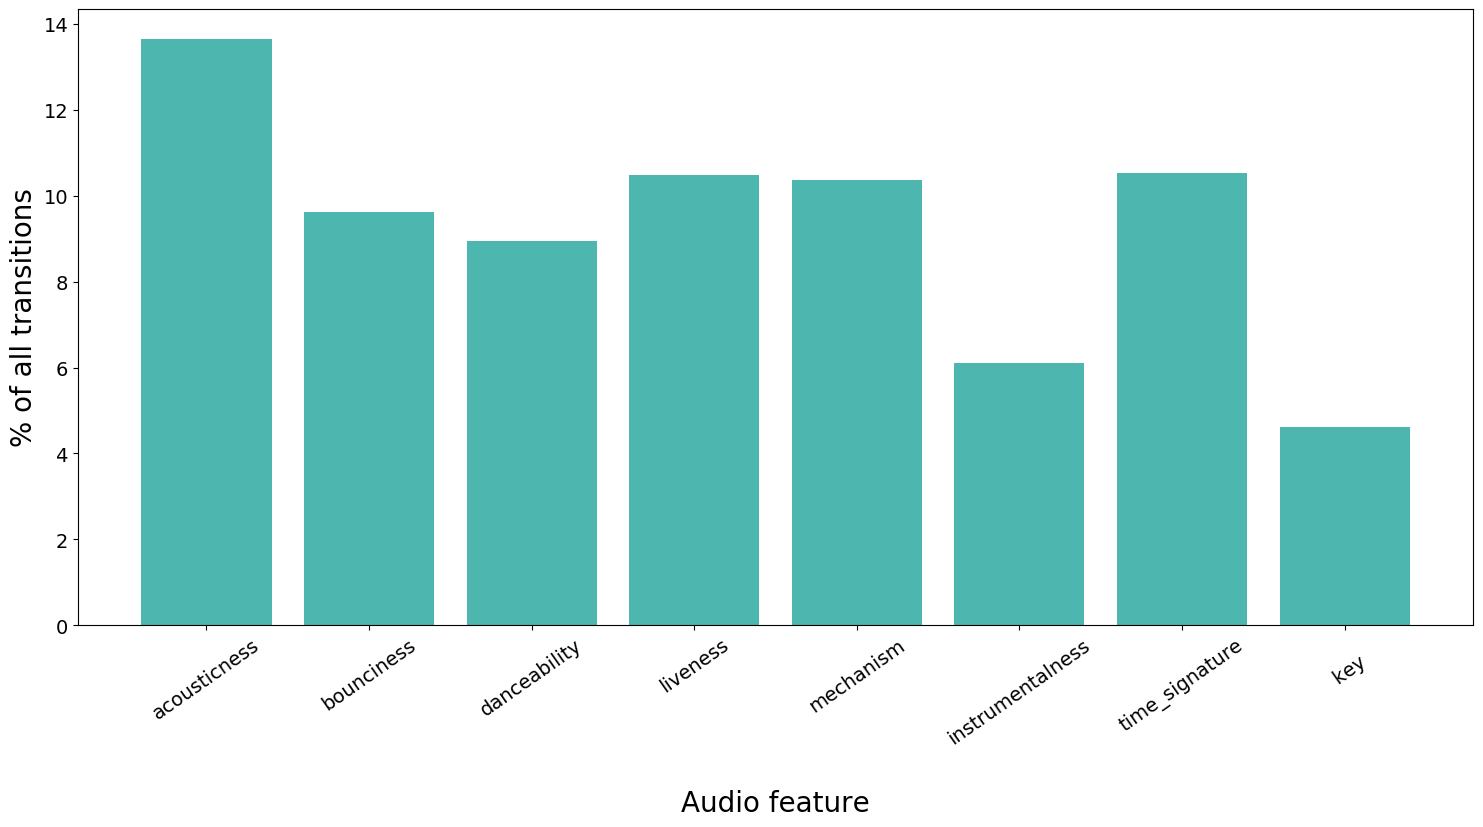

In [141]:
# Percentage of all transitions that are state transitions across selected audio features

# def calc_state_transitions(x):
#     print(len([i for sess in list(x) for i in sess]))
#     print(np.mean([np.mean(sess) if len(sess) > 0 else 0 for sess in list(x)]))
#     return np.mean([np.mean(sess) if len(sess) > 0 else 0 for sess in list(x)]) * 100
#     return np.mean([1 if len(sess) > 0 else 0 for sess in list(x)]) * 100

total_transitions = np.sum(session_lengths) - NUM_EXAMPLES
num_state_transitions = rel_transitions_all.agg(lambda x: len([i for sess in list(x) for i in sess])) / total_transitions * 100
num_flip_transitions = rel_transitions_all.agg(lambda x: np.sum([i for sess in list(x) for i in sess])) / total_transitions * 100

selected_cols = ['acousticness','bounciness','danceability','liveness','mechanism','instrumentalness','time_signature','key']
num_state_transitions = num_state_transitions[selected_cols]
num_flip_transitions = num_flip_transitions[selected_cols]

pct_flip_transitions = num_flip_transitions / num_state_transitions * 100

f, ax = plt.subplots(1,1, figsize=(18,8))

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

width = 0.35
ind = np.arange(len(selected_cols))

ax.bar(num_state_transitions.index, list(num_state_transitions), color='#4db6ae', label='State transitions')
# ax.bar(pct_flip_transitions.index, list(pct_flip_transitions), color='#4db6ae', label='State transitions that result in skip/non-skip transitions')

# ax.bar(ind - width/2, list(num_state_transitions), width, label='State transitions')
# ax.bar(ind + width/2, list(num_flip_transitions), width, label='State transitions that result in skip/non-skip transitions')

ax.set_xticks(ind)
ax.set_xticklabels(selected_cols[:-1] + ['key'.ljust(8).rjust(15)])
ax.set_xlabel('Audio feature', labelpad=30)
ax.set_ylabel('% of all transitions')
# ax.set_ylabel('% of state transitions')
# ax.set_ylim([22,28])
ax.tick_params(axis='x', rotation=35)
# plt.legend()
plt.show()

# plt.savefig('feat_states_norm.png', dpi=300)

## Avg no. of states and transitions for SAT/DSAT sessions

In [136]:
# No. of states per audio attribute
num_states_in_sessions = sess_states.groupby('session_id').nunique()[audio_cols]
num_states_in_sessions['avg_relevance'] = sess_states.groupby('session_id').mean()['relevance']
num_states_in_sessions

acousticness  beat_strength  \
session_id                                                            
0_00074d75-33c6-40b3-99e1-a88e9d015e42             2              1   
0_000bd318-caf2-4366-ba56-26db623b083d             2              1   
0_00130aaf-66be-4824-be3a-d41f8b8caafb             1              1   
0_00137cc4-c737-4b01-9e72-1161f3723b72             1              1   
0_00186766-ee41-49da-8e39-328bbef70f23             1              1   
...                                              ...            ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa             1              3   
0_ffe119a4-9b10-4ede-9119-99046d498767             1              1   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58             2              1   
0_fff3f41f-183a-4664-a623-6db01ab871bc             1              1   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf             2              1   

                                        bounciness  danceability  \
session_id                                                         
0_00074d75-33c6-40b3-99e1-a88e9d015e42           2             1   
0_000bd318-caf2-4366-ba56-26db623b083d           1             1   
0_00130aaf-66be-4824-be3a-d41f8b8caafb           1             1   
0_00137cc4-c737-4b01-9e72-1161f3723b72           1             1   
0_00186766-ee41-49da-8e39-328bbef70f23           1             1   
...                                            ...           ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa           3             2   
0_ffe119a4-9b10-4ede-9119-99046d498767           1             1   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58           1             1   
0_fff3f41f-183a-4664-a623-6db01ab871bc           1             1   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf           1             2   

                                        dyn_range_mean  energy  flatness  \
session_id                                                                 
0_00074d75-33c6-40b3-99e1-a88e9d015e42               2       1         1   
0_000bd318-caf2-4366-ba56-26db623b083d               1       1         1   
0_00130aaf-66be-4824-be3a-d41f8b8caafb               1       1         1   
0_00137cc4-c737-4b01-9e72-1161f3723b72               1       1         1   
0_00186766-ee41-49da-8e39-328bbef70f23               2       1         1   
...                                                ...     ...       ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa               2       1         1   
0_ffe119a4-9b10-4ede-9119-99046d498767               1       1         1   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58               1       1         1   
0_fff3f41f-183a-4664-a623-6db01ab871bc               1       1         1   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf               1       4         2   

                                        instrumentalness  key  liveness  \
session_id                                                                
0_00074d75-33c6-40b3-99e1-a88e9d015e42                 3    2         2   
0_000bd318-caf2-4366-ba56-26db623b083d                 1    1         1   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                 1    1         1   
0_00137cc4-c737-4b01-9e72-1161f3723b72                 1    1         2   
0_00186766-ee41-49da-8e39-328bbef70f23                 1    1         1   
...                                                  ...  ...       ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa                 1    1         1   
0_ffe119a4-9b10-4ede-9119-99046d498767                 1    1         1   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                 1    1         1   
0_fff3f41f-183a-4664-a623-6db01ab871bc                 1    1         1   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                 4    1         1   

                                        loudness  mechanism  mode  organism  \
session_id                                                                    
0_00074d75-33c6-40b3-99e1-a88e9d015e42         2          2     2         2   
0_000bd318-caf2-4366-ba56-26d

In [137]:
num_states_in_sessions.mean().sort_values()

avg_relevance       0.49233
key                 1.08470
tempo               1.14820
valence             1.15380
beat_strength       1.20900
danceability        1.22330
energy              1.22380
organism            1.22640
flatness            1.23360
mechanism           1.23940
bounciness          1.24560
loudness            1.26480
dyn_range_mean      1.28530
instrumentalness    1.30010
liveness            1.31190
acousticness        1.35160
speechiness         1.38320
mode                1.54280
time_signature      1.57100
dtype: float64

In [138]:
# Top 5 features with most states
top5_feats = ['liveness','acousticness','speechiness','mode','time_signature']

In [139]:
num_states_in_sessions_mean = pd.DataFrame(num_states_in_sessions[top5_feats].mean(axis=1), columns=['mean_states'])
num_states_in_sessions_mean['avg_relevance'] = sess_states.groupby('session_id').mean()['relevance']
num_states_in_sessions_mean

mean_states  avg_relevance
session_id                                                        
0_00074d75-33c6-40b3-99e1-a88e9d015e42          2.2       0.400000
0_000bd318-caf2-4366-ba56-26db623b083d          1.2       0.285714
0_00130aaf-66be-4824-be3a-d41f8b8caafb          1.8       0.250000
0_00137cc4-c737-4b01-9e72-1161f3723b72          1.4       0.350000
0_00186766-ee41-49da-8e39-328bbef70f23          1.2       0.727273
...                                             ...            ...
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa          1.4       0.100000
0_ffe119a4-9b10-4ede-9119-99046d498767          1.4       0.400000
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58          1.2       0.400000
0_fff3f41f-183a-4664-a623-6db01ab871bc          1.0       0.833333
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf          1.4       0.888889

[10000 rows x 2 columns]

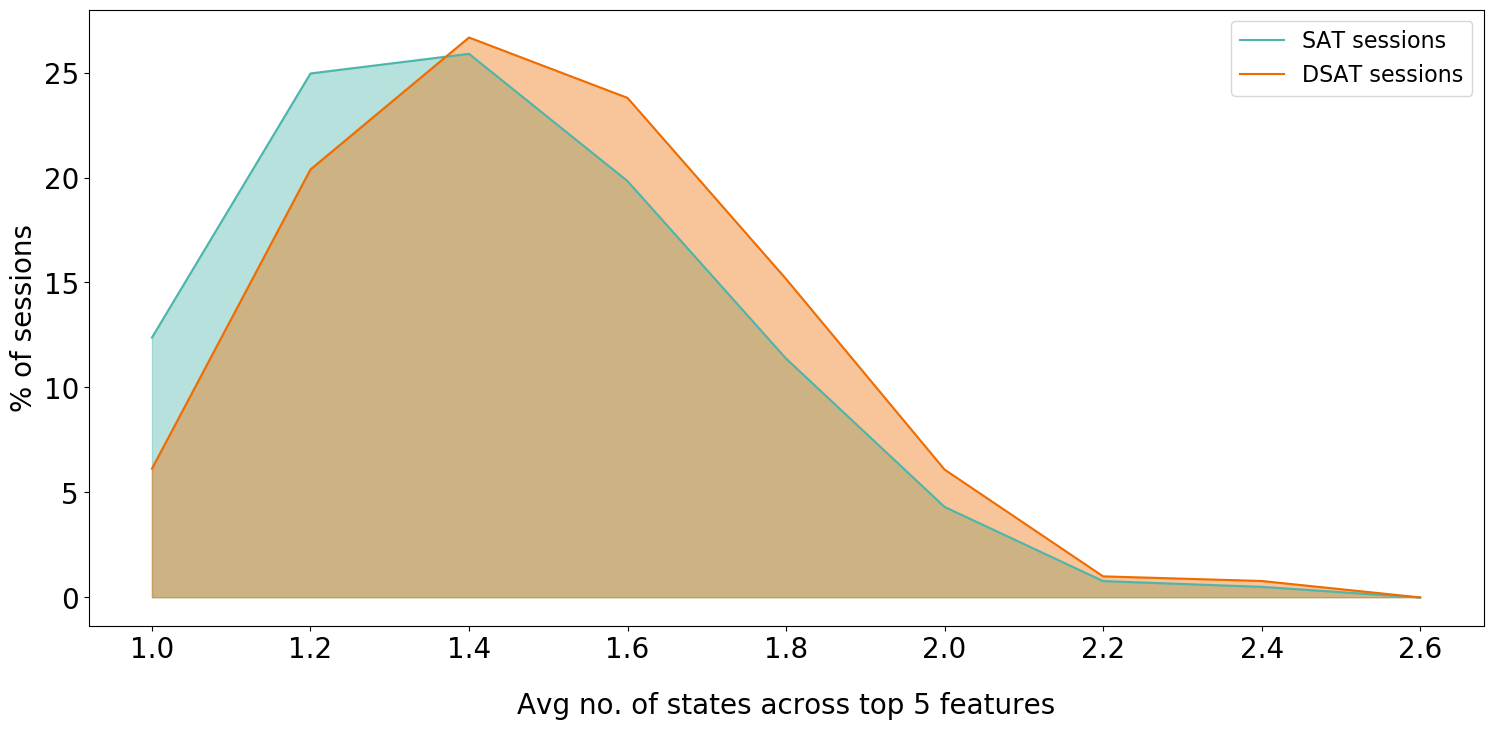

In [140]:
# Distribution of sessions across average number of states of top 5 features with most states
sat_sess = num_states_in_sessions_mean[num_states_in_sessions_mean['avg_relevance']>=0.75]
dsat_sess = num_states_in_sessions_mean[num_states_in_sessions_mean['avg_relevance']<=0.25]

sat_sess_avg_states = sat_sess.round(1)['mean_states'].value_counts().sort_index() / len(sat_sess) * 100
dsat_sess_avg_states = dsat_sess.round(1)['mean_states'].value_counts().sort_index() / len(dsat_sess) * 100

f, ax = plt.subplots(1,1, figsize=(18,8))

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

sat_sess_avg_states_poly = np.poly1d(np.polyfit(sat_sess_avg_states.index,list(sat_sess_avg_states),5))(sat_sess_avg_states.index)
dsat_sess_avg_states_poly = np.poly1d(np.polyfit(dsat_sess_avg_states.index,list(dsat_sess_avg_states),5))(dsat_sess_avg_states.index)

ax.plot(sat_sess_avg_states.index, sat_sess_avg_states_poly, label='SAT sessions', color='#4db6ac')
ax.plot(dsat_sess_avg_states.index, dsat_sess_avg_states_poly, label='DSAT sessions', color='#ef6c00')

ax.set_xlabel('Avg no. of states across top 5 features', labelpad=20)
ax.set_ylabel('% of sessions')
plt.fill_between(sat_sess_avg_states.index, sat_sess_avg_states_poly, color='#4db6ac', alpha=0.4)
plt.fill_between(dsat_sess_avg_states.index, dsat_sess_avg_states_poly, color='#ef6c00', alpha=0.4)
plt.legend()
plt.show()

In [142]:
# No. of transitions per audio attribute
num_transitions_in_sessions = rel_transitions_all.applymap(len)
num_transitions_in_sessions['avg_relevance'] = sess_states.groupby('session_id').mean()['relevance']
num_transitions_in_sessions

acousticness  beat_strength  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42             1              0   
0_000bd318-caf2-4366-ba56-26db623b083d             6              0   
0_00130aaf-66be-4824-be3a-d41f8b8caafb             0              0   
0_00137cc4-c737-4b01-9e72-1161f3723b72             0              0   
0_00186766-ee41-49da-8e39-328bbef70f23             0              0   
...                                              ...            ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa             0             12   
0_ffe119a4-9b10-4ede-9119-99046d498767             0              0   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58             4              0   
0_fff3f41f-183a-4664-a623-6db01ab871bc             0              0   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf            11              0   

                                        bounciness  danceability  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42           3             0   
0_000bd318-caf2-4366-ba56-26db623b083d           0             0   
0_00130aaf-66be-4824-be3a-d41f8b8caafb           0             0   
0_00137cc4-c737-4b01-9e72-1161f3723b72           0             0   
0_00186766-ee41-49da-8e39-328bbef70f23           0             0   
...                                            ...           ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa          14            10   
0_ffe119a4-9b10-4ede-9119-99046d498767           0             0   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58           0             0   
0_fff3f41f-183a-4664-a623-6db01ab871bc           0             0   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf           0             5   

                                        dyn_range_mean  energy  flatness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42               1       0         0   
0_000bd318-caf2-4366-ba56-26db623b083d               0       0         0   
0_00130aaf-66be-4824-be3a-d41f8b8caafb               0       0         0   
0_00137cc4-c737-4b01-9e72-1161f3723b72               0       0         0   
0_00186766-ee41-49da-8e39-328bbef70f23               3       0         0   
...                                                ...     ...       ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa              12       0         0   
0_ffe119a4-9b10-4ede-9119-99046d498767               0       0         0   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58               0       0         0   
0_fff3f41f-183a-4664-a623-6db01ab871bc               0       0         0   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf               0      11        11   

                                        instrumentalness  key  liveness  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42                 6    6         4   
0_000bd318-caf2-4366-ba56-26db623b083d                 0    0         0   
0_00130aaf-66be-4824-be3a-d41f8b8caafb                 0    0         0   
0_00137cc4-c737-4b01-9e72-1161f3723b72                 0    0         4   
0_00186766-ee41-49da-8e39-328bbef70f23                 0    0         0   
...                                                  ...  ...       ...   
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa                 0    0         0   
0_ffe119a4-9b10-4ede-9119-99046d498767                 0    0         0   
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58                 0    0         0   
0_fff3f41f-183a-4664-a623-6db01ab871bc                 0    0         0   
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf                13    0         0   

                                        loudness  mechanism  mode  organism  \
0_00074d75-33c6-40b3-99e1-a88e9d015e42         3          5     7         3   
0_000bd318-caf2-4366-ba56-26db623b083d         0          0     0         0   
0_00130aaf-66be-4824-be3a-d41f8b8caafb         0         11     8         0   
0_00137cc4-c737-4b01-9e72-1161f3723b72         0          0    10         0   
0_00186766-ee41-49da-8e39-328bbef70f23         1          0     0         0   
...                                          ...        ...   ...       ...   
0_f

In [143]:
num_transitions_in_sessions_mean = pd.DataFrame(num_transitions_in_sessions[top5_feats].mean(axis=1), columns=['mean_transitions'])
num_transitions_in_sessions_mean['avg_relevance'] = sess_states.groupby('session_id').mean()['relevance']
num_transitions_in_sessions_mean

mean_transitions  avg_relevance
0_00074d75-33c6-40b3-99e1-a88e9d015e42               3.2       0.400000
0_000bd318-caf2-4366-ba56-26db623b083d               1.2       0.285714
0_00130aaf-66be-4824-be3a-d41f8b8caafb               4.6       0.250000
0_00137cc4-c737-4b01-9e72-1161f3723b72               2.8       0.350000
0_00186766-ee41-49da-8e39-328bbef70f23               0.4       0.727273
...                                                  ...            ...
0_ffdc370d-59c3-4b71-a5e8-c5b979fac3aa               4.2       0.100000
0_ffe119a4-9b10-4ede-9119-99046d498767               2.8       0.400000
0_ffeb9687-caff-4b4a-9cdd-602f4bc97e58               0.8       0.400000
0_fff3f41f-183a-4664-a623-6db01ab871bc               0.0       0.833333
0_ffff16ed-55b2-455d-ab42-f716d50ffbaf               3.2       0.888889

[10000 rows x 2 columns]

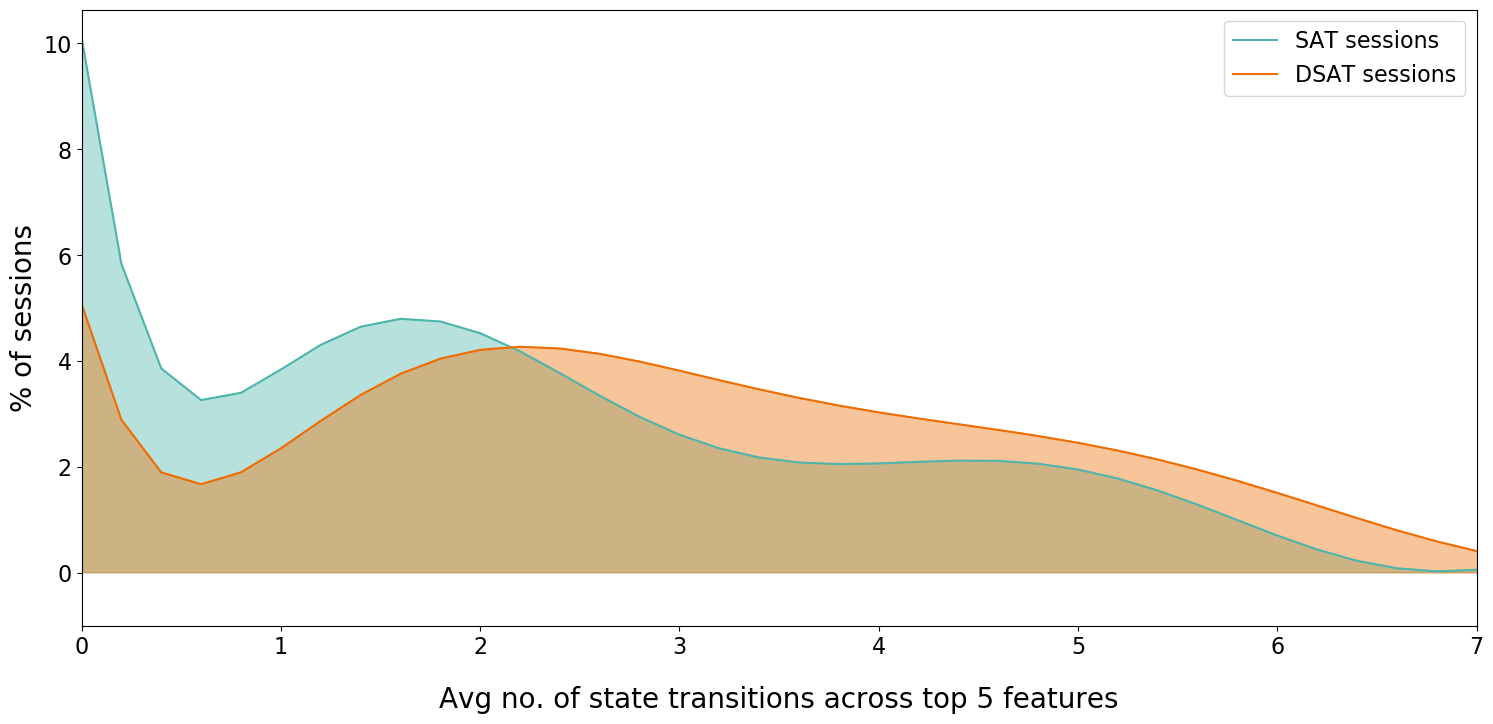

In [147]:
# Distribution of sessions across average number of state transitions of top 5 features with most state transitions
sat_sess = num_transitions_in_sessions_mean[num_transitions_in_sessions_mean['avg_relevance']>=0.75]
dsat_sess = num_transitions_in_sessions_mean[num_transitions_in_sessions_mean['avg_relevance']<=0.25]

sat_sess_avg_transitions = sat_sess.round(1)['mean_transitions'].value_counts().sort_index() / len(sat_sess) * 100
dsat_sess_avg_transitions = dsat_sess.round(1)['mean_transitions'].value_counts().sort_index() / len(dsat_sess) * 100

f, ax = plt.subplots(1,1, figsize=(18,8))

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

sat_sess_avg_transitions_poly = np.poly1d(np.polyfit(sat_sess_avg_transitions.index,list(sat_sess_avg_transitions),8))(sat_sess_avg_transitions.index)
dsat_sess_avg_transitions_poly = np.poly1d(np.polyfit(dsat_sess_avg_transitions.index,list(dsat_sess_avg_transitions),8))(dsat_sess_avg_transitions.index)

ax.plot(sat_sess_avg_transitions.index, sat_sess_avg_transitions_poly, label='SAT sessions', color='#4db6ac')
ax.plot(dsat_sess_avg_transitions.index, dsat_sess_avg_transitions_poly, label='DSAT sessions', color='#ef6c00')

ax.set_xlabel('Avg no. of state transitions across top 5 features', labelpad=20)
ax.set_ylabel('% of sessions')
ax.set_xlim([0,7])
plt.fill_between(sat_sess_avg_transitions.index, sat_sess_avg_transitions_poly, color='#4db6ac', alpha=0.4)
plt.fill_between(dsat_sess_avg_transitions.index, dsat_sess_avg_transitions_poly, color='#ef6c00', alpha=0.4)
plt.legend()
plt.show()

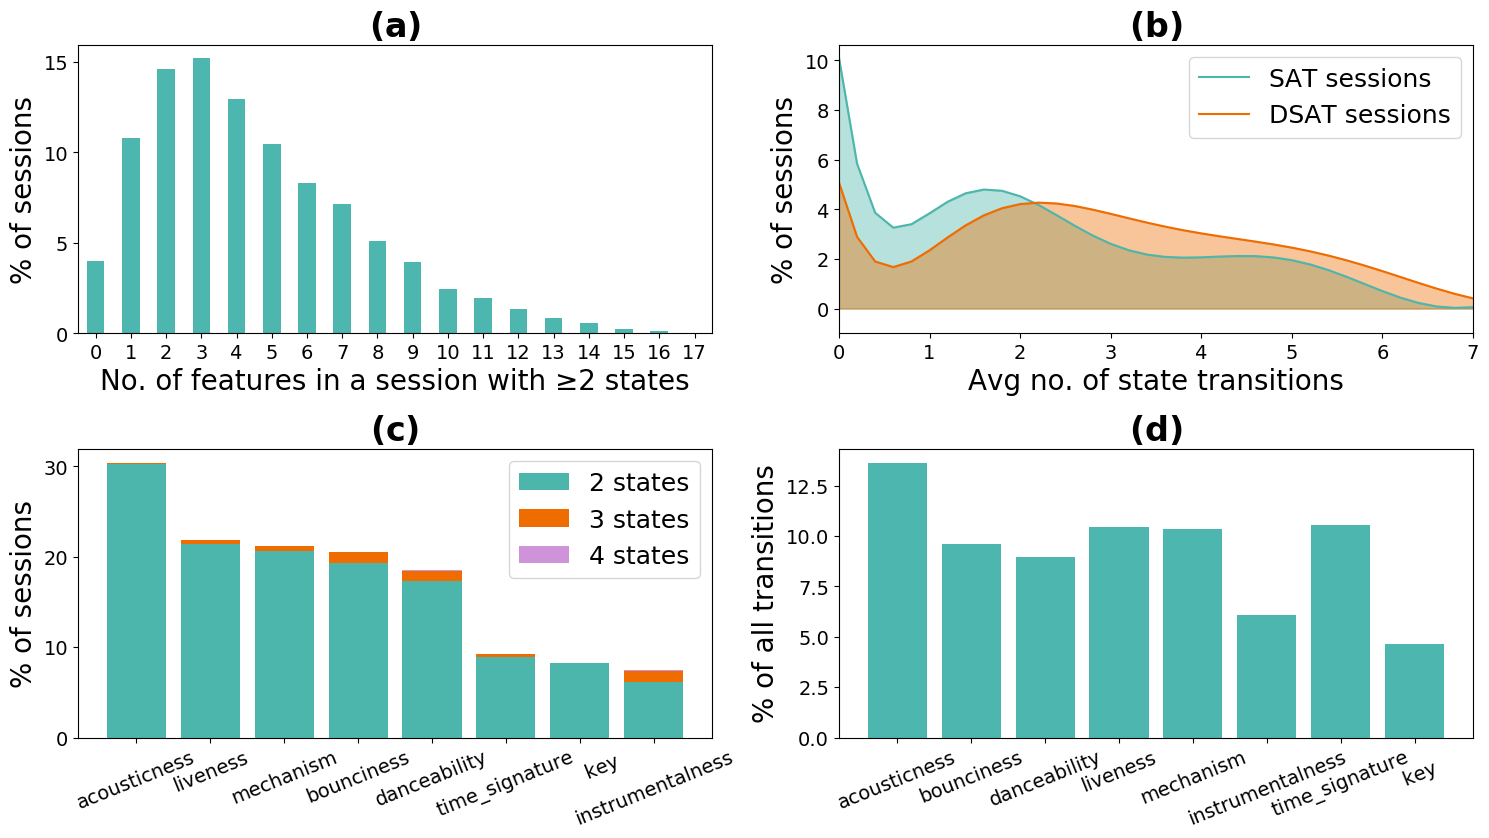

In [146]:
# Summary plots
f, ax = plt.subplots(2,2, figsize=(18,9))

plt.rcParams.update(plt.rcParamsDefault)
plt.subplots_adjust(hspace=0.4)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

ax[0][0].set_title(r"$\bf{(a)}$", fontsize=24)
ax[0][0].set_ylabel('% of sessions')
ax[0][0].set_xlabel('No. of features in a session with ≥2 states')
ax[0][0].set_xticks(range(0,25))
t2.plot(kind='bar', ax=ax[0][0], color='#4db6ae', legend=None)
ax[0][0].set_xticklabels(t2.index)
ax[0][0].tick_params(axis='x', rotation=0);

cols_23 = ['acousticness','liveness','mechanism','bounciness','danceability','time_signature','key'.ljust(5).rjust(15),'instrumentalness']
ax[1][0].set_title(r"$\bf{(c)}$", fontsize=24)
cumsum = np.zeros(len(cols_23))
ax[1][0].bar(cols_23, t1.loc[2], bottom=cumsum, label='{} states'.format(2), color='#4db6ac')
cumsum += t1.loc[2]
ax[1][0].bar(cols_23, t1.loc[3], bottom=cumsum, label='{} states'.format(3), color='#ef6c00')
cumsum += t1.loc[3]
ax[1][0].bar(cols_23, t1.loc[4], bottom=cumsum, label='{} states'.format(4), color='#ce93d8')
cumsum += t1.loc[4]
# ax[1][0].set_xlabel('Audio feature')
ax[1][0].set_ylabel('% of sessions')
ax[1][0].tick_params(axis='x', rotation=22)
ax[1][0].legend()

ax[1][1].set_title(r"$\bf{(d)}$", fontsize=24)
ax[1][1].bar(num_state_transitions.index, list(num_state_transitions), color='#4db6ae', label='State transitions')
# ax[1][1].set_xticks([0,3,4,1,2,6,7,5])
ax[1][1].set_xticklabels(selected_cols[:-1] + ['key'.ljust(8).rjust(15)])
ax[1][1].set_ylabel('% of all transitions')
ax[1][1].tick_params(axis='x', rotation=22)

ax[0][1].set_title(r"$\bf{(b)}$", fontsize=24)
ax[0][1].plot(sat_sess_avg_transitions.index, sat_sess_avg_transitions_poly, label='SAT sessions', color='#4db6ac')
ax[0][1].plot(dsat_sess_avg_transitions.index, dsat_sess_avg_transitions_poly, label='DSAT sessions', color='#ef6c00')
ax[0][1].set_xlabel('Avg no. of state transitions')
ax[0][1].set_ylabel('% of sessions')
ax[0][1].set_xlim([0,7])
ax[0][1].fill_between(sat_sess_avg_transitions.index, sat_sess_avg_transitions_poly, color='#4db6ac', alpha=0.4)
ax[0][1].fill_between(dsat_sess_avg_transitions.index, dsat_sess_avg_transitions_poly, color='#ef6c00', alpha=0.4)
ax[0][1].legend()
plt.show()
